In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization,
    GlobalAveragePooling2D, Reshape, multiply, Add, Activation,concatenate,ReLU,
    DepthwiseConv2D, SeparableConv2D  # Import DepthwiseConv2D here
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import numpy as np
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
import subprocess
import time
import threading

In [2]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Data processing

In [3]:
dataset_path =  'E:\Download\JPEGImages (2)\JPEGImages (2)\dataset'
num_classes=45
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # 随机旋转度数范围
    width_shift_range=0.2, # 随机水平移动比例范围
    height_shift_range=0.2, # 随机竖直移动比例范围
    shear_range=0.2, # 剪切变换的程度
    zoom_range=0.2, # 随机缩放的范围
    horizontal_flip=True, # 随机水平翻转
    brightness_range=[0.8, 1.2], # 随机亮度变换的范围
    fill_mode='nearest', # 填充新创建像素的方法
    validation_split=0.4 # 40% 用于验证
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 26997 images belonging to 45 classes.
Found 17996 images belonging to 45 classes.


图像数据最小值: 0.0
图像数据最大值: 1.0


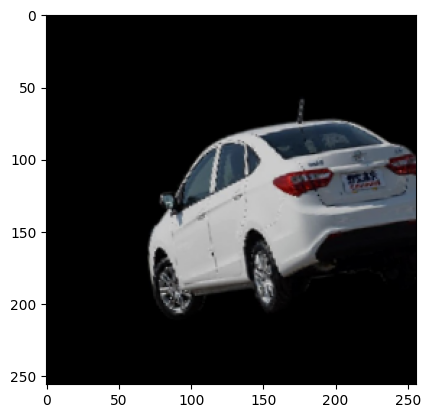

In [4]:
import matplotlib.pyplot as plt

# 获取数据集的类别信息
class_indices = train_generator.class_indices
labels = list(class_indices.keys())

def plot_images(generator, count=5):
    # 生成器生成一批图片
    x,y = next(generator)
    plt.figure(figsize=(20, 10))
    for i in range(count):
        plt.subplot(1, count, i+1)
        # 显示图片
        # 注意: generator进行了rescale, 因此要显示原始图片，需要还原数据
        plt.imshow(x[i] * 255.0)  # 将图片还原至0-255的像素值
        plt.title("Class: " + labels[np.argmax(y[i])])  # 显示图片类别
        plt.axis('off')
    plt.show()
x, y = next(validation_generator)  # 假设 x 是图像数据，y 是标签

# 检查图像数据范围
print("图像数据最小值:", np.min(x))
print("图像数据最大值:", np.max(x))

# 裁剪图像数据到[0, 1]范围
x_clipped = np.clip(x, 0, 1)

# 现在尝试显示裁剪后的图像
plt.imshow(x_clipped[0])  # 显示第一张图像
plt.show()




# Experiment 1: Compare different Learning rate

| Setting Item        | Value                                    |
|---------------------|------------------------------------------|
| Train Images        | 26,997 images belonging to 45 classes    |
| Validation Images   | 17,996 images belonging to 45 classes    |
| Input Size          | (256, 256, 3)                            |
| Model               | custom_resnet50 (resnet50+se+dscnn+inception) |
| Epochs              | 30                                       |
| Batch Size          | 32                                       |
| Optimizer           | Adam                                     |
| Loss                | Categorical Crossentropy                 |

In [5]:
def squeeze_excite_block(input_tensor, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    se_shape = (1, 1, channels)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)

    # 扩展路径1
    se_1 = layers.Dense(channels // reduction_ratio * 2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_1 = layers.Dense(channels // reduction_ratio, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se_1)
    se_1 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_1)

    # 扩展路径2
    se_2 = layers.Dense(channels // reduction_ratio * 4, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_2 = layers.Dropout(0.5)(se_2)
    se_2 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_2)

    se = layers.add([se_1, se_2])
    return layers.multiply([input_tensor, se])

def identity_block(input_tensor, kernel_size, filters, stage, block, ratio=16):
    """A block that has no conv layer at shortcut, with an SE block."""
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = squeeze_excite_block(x, ratio)  # Add SE block

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), ratio=16):
    """A block that has a conv layer at shortcut, with an SE block."""
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = squeeze_excite_block(x, ratio)  # Add SE block

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x
    
def residual_inception_block(input_tensor, filters):
    # 分支1：1x1卷积
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)

    # 分支2：1x1卷积后接3x3卷积
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)

    # 分支3：1x1卷积后接5x5卷积
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)

    # 分支4：3x3最大池化后接1x1卷积
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)

    # 合并所有分支
    x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)

    # 残差连接
    shortcut = layers.Conv2D(4 * filters, (1, 1), strides=(1, 1), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x
    
def depthwise_separable_conv_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=False, reduction_ratio=16):
    # Depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=stride, depth_multiplier=1, padding='same', kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Pointwise convolution
    x = layers.Conv2D(filters, 1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Shortcut path, if required
    if conv_shortcut or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_initializer='he_normal')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    # Apply SE block
    x = squeeze_excite_block(x, reduction_ratio)

    # Combine main path and shortcut
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x
    
# Building ResNet-50
def custom_resnet50_3(input_shape=(256, 256, 3), num_classes=45):
    img_input = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), ratio=16)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', ratio=16)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', ratio=16)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', ratio=16)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', ratio=16)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', ratio=16)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', ratio=16)

    x = residual_inception_block(x, 512)

    x = depthwise_separable_conv_block(x, 1024, kernel_size=3, stride=1, conv_shortcut=True, reduction_ratio=16)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', ratio=16)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', ratio=16)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', ratio=16)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', ratio=16)

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='fc1000')(x)

    model = models.Model(img_input, x)
    return model




## Learning rate = 0.0001

In [7]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30, 
)

Epoch 1/30
843/843 [==============================] - 446s 525ms/step - loss: 2.7219 - accuracy: 0.3026 - val_loss: 2.4908 - val_accuracy: 0.4035
Epoch 2/30
843/843 [==============================] - 442s 525ms/step - loss: 1.5052 - accuracy: 0.5985 - val_loss: 1.4570 - val_accuracy: 0.6166
Epoch 3/30
843/843 [==============================] - 440s 522ms/step - loss: 1.1203 - accuracy: 0.6958 - val_loss: 1.2328 - val_accuracy: 0.6663
Epoch 4/30
843/843 [==============================] - 442s 524ms/step - loss: 0.9239 - accuracy: 0.7466 - val_loss: 1.0533 - val_accuracy: 0.7173
Epoch 5/30
843/843 [==============================] - 445s 528ms/step - loss: 0.7915 - accuracy: 0.7800 - val_loss: 1.0022 - val_accuracy: 0.7319
Epoch 6/30
843/843 [==============================] - 445s 528ms/step - loss: 0.6774 - accuracy: 0.8123 - val_loss: 1.0758 - val_accuracy: 0.7172
Epoch 7/30
843/843 [==============================] - 442s 525ms/step - loss: 0.6104 - accuracy: 0.8281 - val_loss: 1.1384 -

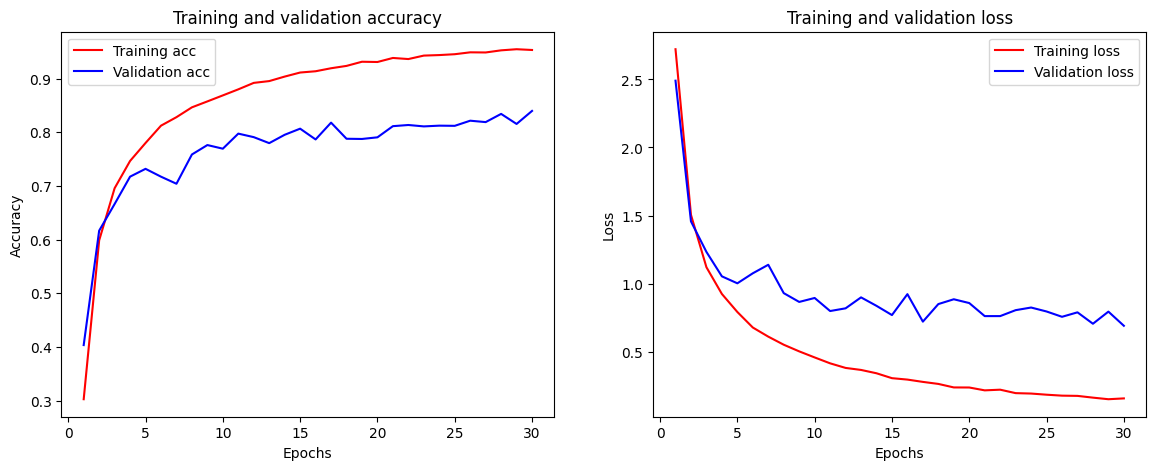

In [9]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Learning rate = 0.0005

In [10]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30, 
)

Epoch 1/30
843/843 [==============================] - 455s 537ms/step - loss: 3.6198 - accuracy: 0.0770 - val_loss: 3.5586 - val_accuracy: 0.0964
Epoch 2/30
843/843 [==============================] - 455s 540ms/step - loss: 2.9056 - accuracy: 0.2336 - val_loss: 3.0018 - val_accuracy: 0.2314
Epoch 3/30
843/843 [==============================] - 451s 535ms/step - loss: 2.2156 - accuracy: 0.4033 - val_loss: 2.3687 - val_accuracy: 0.3661
Epoch 4/30
843/843 [==============================] - 451s 535ms/step - loss: 1.7752 - accuracy: 0.5164 - val_loss: 1.9434 - val_accuracy: 0.4842
Epoch 5/30
843/843 [==============================] - 452s 536ms/step - loss: 1.4940 - accuracy: 0.5913 - val_loss: 1.7235 - val_accuracy: 0.5358
Epoch 6/30
843/843 [==============================] - 450s 534ms/step - loss: 1.3009 - accuracy: 0.6379 - val_loss: 1.6144 - val_accuracy: 0.5631
Epoch 7/30
843/843 [==============================] - 451s 535ms/step - loss: 1.1642 - accuracy: 0.6744 - val_loss: 1.3776 -

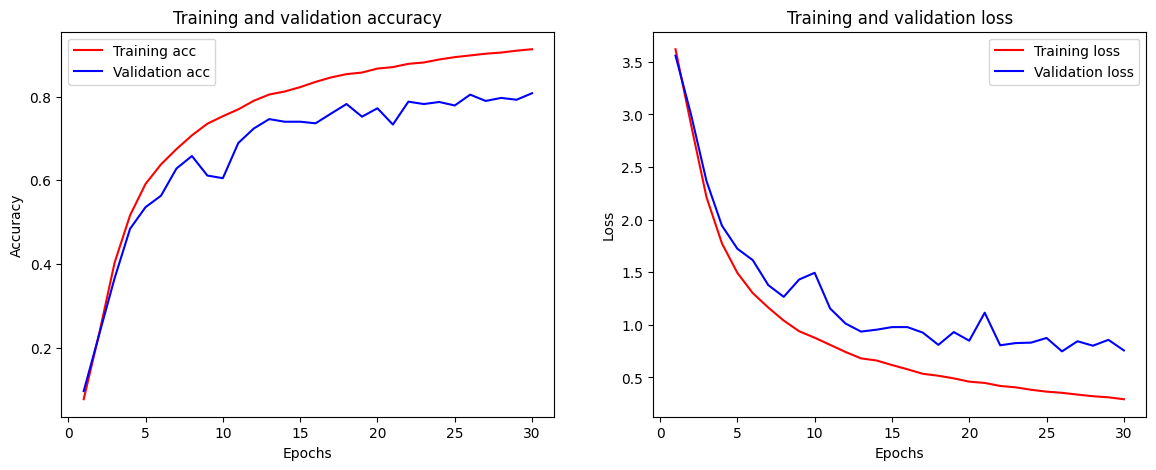

In [12]:
import matplotlib.pyplot as plt



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Learning rate = 0.0010

In [13]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.0010), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,  
)

Epoch 1/30
843/843 [==============================] - 444s 523ms/step - loss: 3.7592 - accuracy: 0.0441 - val_loss: 3.8512 - val_accuracy: 0.0247
Epoch 2/30
843/843 [==============================] - 446s 529ms/step - loss: 3.6020 - accuracy: 0.0747 - val_loss: 3.6447 - val_accuracy: 0.0659
Epoch 3/30
843/843 [==============================] - 442s 524ms/step - loss: 3.4603 - accuracy: 0.1051 - val_loss: 3.5008 - val_accuracy: 0.1028
Epoch 4/30
843/843 [==============================] - 443s 525ms/step - loss: 3.3059 - accuracy: 0.1437 - val_loss: 3.3489 - val_accuracy: 0.1337
Epoch 5/30
843/843 [==============================] - 427s 507ms/step - loss: 3.0810 - accuracy: 0.1927 - val_loss: 3.1144 - val_accuracy: 0.1877
Epoch 6/30
843/843 [==============================] - 427s 507ms/step - loss: 2.8067 - accuracy: 0.2573 - val_loss: 2.9930 - val_accuracy: 0.2065
Epoch 7/30
843/843 [==============================] - 432s 512ms/step - loss: 2.5303 - accuracy: 0.3255 - val_loss: 2.5426 -

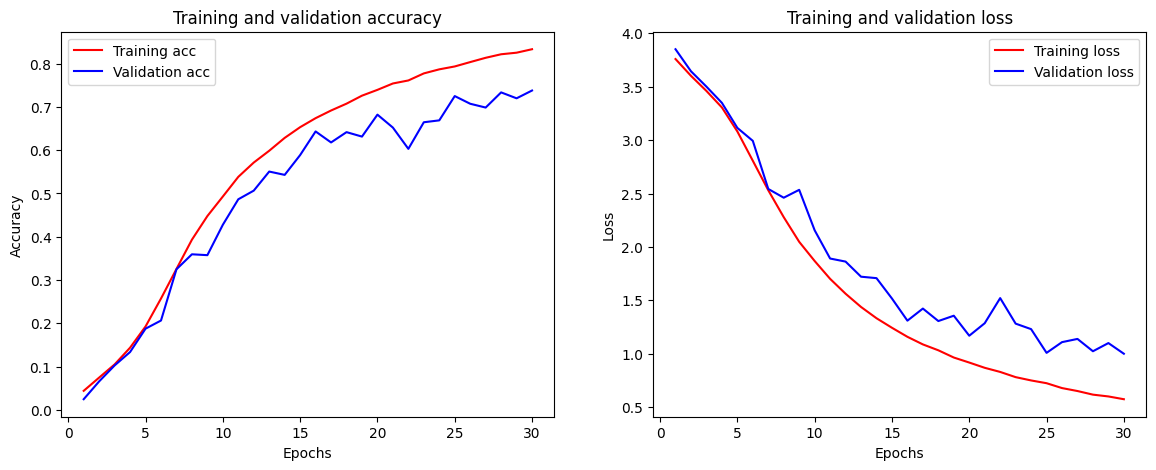

In [15]:
import matplotlib.pyplot as plt



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Learning rate = 0.0050

In [16]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.0050), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30, 
)

Epoch 1/30
843/843 [==============================] - 448s 528ms/step - loss: 3.8798 - accuracy: 0.0235 - val_loss: 3.8072 - val_accuracy: 0.0238
Epoch 2/30
843/843 [==============================] - 448s 532ms/step - loss: 3.8068 - accuracy: 0.0278 - val_loss: 3.7914 - val_accuracy: 0.0304
Epoch 3/30
843/843 [==============================] - 444s 526ms/step - loss: 3.7953 - accuracy: 0.0268 - val_loss: 3.8158 - val_accuracy: 0.0231
Epoch 4/30
843/843 [==============================] - 442s 524ms/step - loss: 3.7861 - accuracy: 0.0298 - val_loss: 3.7768 - val_accuracy: 0.0282
Epoch 5/30
843/843 [==============================] - 440s 523ms/step - loss: 3.7801 - accuracy: 0.0301 - val_loss: 3.9568 - val_accuracy: 0.0234
Epoch 6/30
843/843 [==============================] - 442s 525ms/step - loss: 3.7830 - accuracy: 0.0307 - val_loss: 3.8572 - val_accuracy: 0.0217
Epoch 7/30
843/843 [==============================] - 441s 524ms/step - loss: 3.8082 - accuracy: 0.0204 - val_loss: 3.8074 -

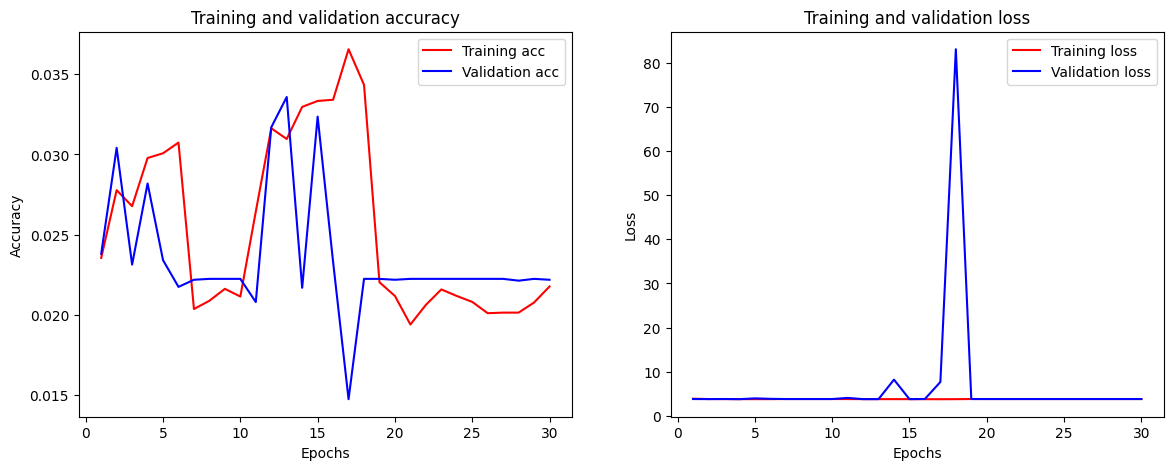

In [18]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Learning rate = 0.0100

In [19]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.0100), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30, 
)

Epoch 1/30
843/843 [==============================] - 448s 529ms/step - loss: 3.8871 - accuracy: 0.0214 - val_loss: 3.8083 - val_accuracy: 0.0222
Epoch 2/30
843/843 [==============================] - 444s 526ms/step - loss: 3.8117 - accuracy: 0.0195 - val_loss: 3.8095 - val_accuracy: 0.0222
Epoch 3/30
843/843 [==============================] - 444s 527ms/step - loss: 3.8103 - accuracy: 0.0209 - val_loss: 3.8083 - val_accuracy: 0.0222
Epoch 4/30
843/843 [==============================] - 446s 529ms/step - loss: 3.8107 - accuracy: 0.0206 - val_loss: 3.8082 - val_accuracy: 0.0222
Epoch 5/30
843/843 [==============================] - 451s 535ms/step - loss: 3.8103 - accuracy: 0.0205 - val_loss: 3.8085 - val_accuracy: 0.0222
Epoch 6/30
843/843 [==============================] - 448s 531ms/step - loss: 3.8106 - accuracy: 0.0217 - val_loss: 3.8087 - val_accuracy: 0.0222
Epoch 7/30
843/843 [==============================] - 445s 528ms/step - loss: 3.8104 - accuracy: 0.0200 - val_loss: 3.8090 -

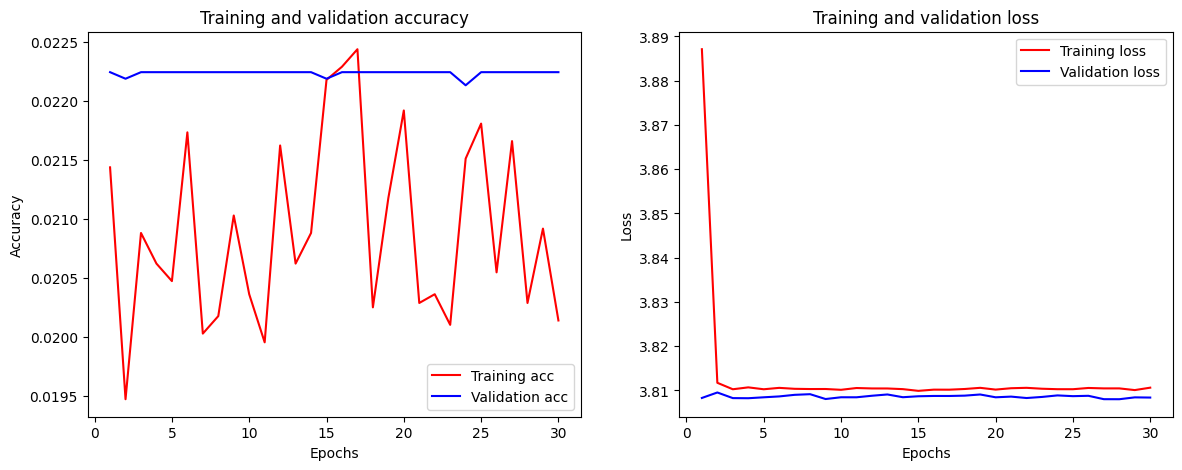

In [21]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Learning rate = 0.0500

In [22]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.0500), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30, 
)

Epoch 1/30
843/843 [==============================] - 449s 529ms/step - loss: 4.3749 - accuracy: 0.0224 - val_loss: 3.8210 - val_accuracy: 0.0222
Epoch 2/30
843/843 [==============================] - 443s 525ms/step - loss: 3.8216 - accuracy: 0.0222 - val_loss: 3.8156 - val_accuracy: 0.0221
Epoch 3/30
843/843 [==============================] - 441s 523ms/step - loss: 3.8213 - accuracy: 0.0208 - val_loss: 3.8197 - val_accuracy: 0.0222
Epoch 4/30
843/843 [==============================] - 445s 528ms/step - loss: 3.8223 - accuracy: 0.0217 - val_loss: 3.8155 - val_accuracy: 0.0222
Epoch 5/30
843/843 [==============================] - 440s 522ms/step - loss: 3.8227 - accuracy: 0.0209 - val_loss: 3.8194 - val_accuracy: 0.0222
Epoch 6/30
843/843 [==============================] - 446s 529ms/step - loss: 4.0454 - accuracy: 0.0211 - val_loss: 3.8933 - val_accuracy: 0.0222
Epoch 7/30
843/843 [==============================] - 449s 533ms/step - loss: 3.8236 - accuracy: 0.0215 - val_loss: 3.8222 -

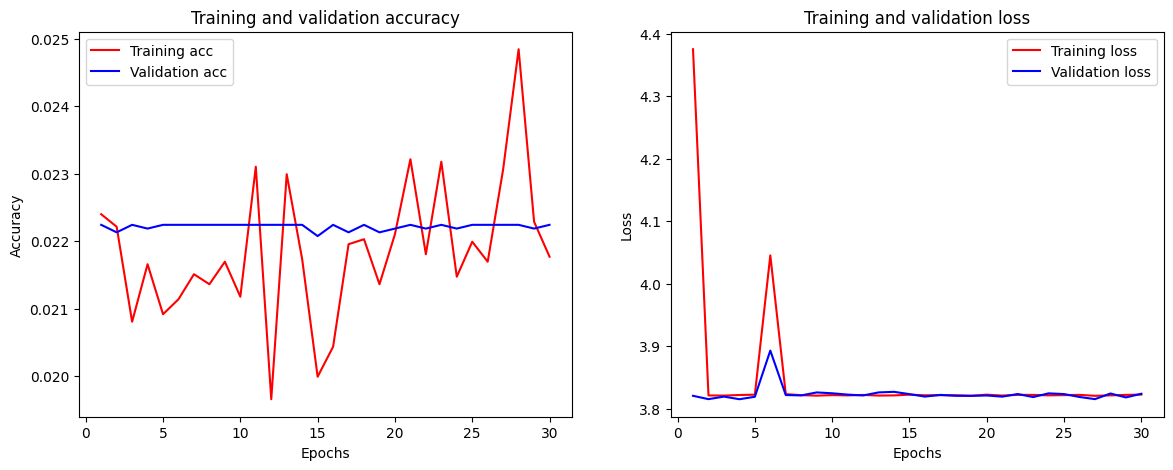

In [24]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Learning rate = 0.1000

In [25]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.1000), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,  
)

Epoch 1/30
843/843 [==============================] - 464s 547ms/step - loss: 6.7337 - accuracy: 0.0218 - val_loss: 3.8365 - val_accuracy: 0.0224
Epoch 2/30
843/843 [==============================] - 459s 545ms/step - loss: 3.8358 - accuracy: 0.0211 - val_loss: 3.8372 - val_accuracy: 0.0224
Epoch 3/30
843/843 [==============================] - 461s 547ms/step - loss: 3.8361 - accuracy: 0.0220 - val_loss: 3.8381 - val_accuracy: 0.0222
Epoch 4/30
843/843 [==============================] - 467s 554ms/step - loss: 3.8352 - accuracy: 0.0208 - val_loss: 3.8302 - val_accuracy: 0.0223
Epoch 5/30
843/843 [==============================] - 461s 547ms/step - loss: 3.8371 - accuracy: 0.0204 - val_loss: 3.8330 - val_accuracy: 0.0222
Epoch 6/30
843/843 [==============================] - 459s 545ms/step - loss: 3.8358 - accuracy: 0.0216 - val_loss: 3.8363 - val_accuracy: 0.0223
Epoch 7/30
843/843 [==============================] - 489s 580ms/step - loss: 3.8384 - accuracy: 0.0217 - val_loss: 3.8414 -

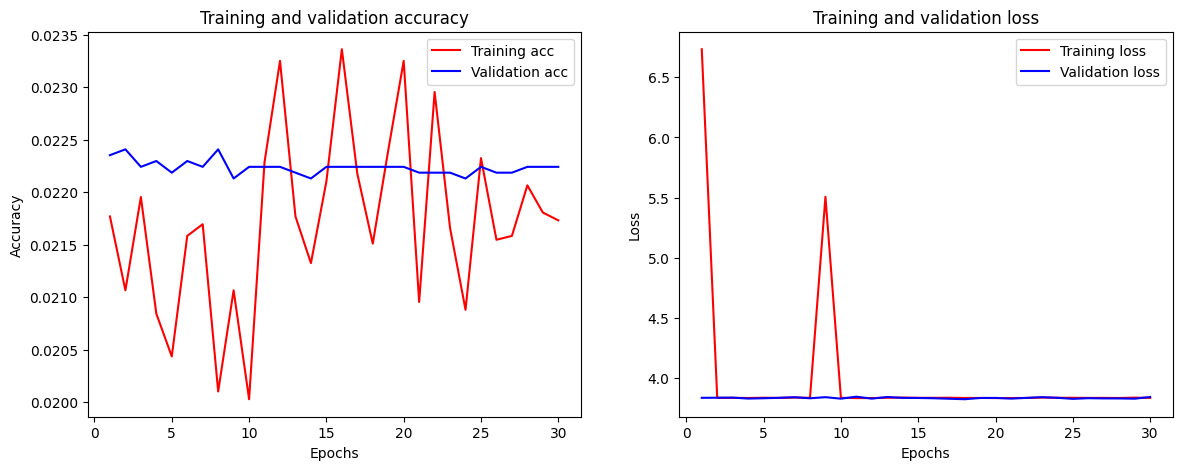

In [27]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Learning rate = 0.5000

In [28]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.5000), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,  
)

Epoch 1/30
843/843 [==============================] - 452s 533ms/step - loss: 65.1006 - accuracy: 0.0224 - val_loss: 3.9511 - val_accuracy: 0.0222
Epoch 2/30
843/843 [==============================] - 447s 530ms/step - loss: 3.9443 - accuracy: 0.0215 - val_loss: 3.9812 - val_accuracy: 0.0221
Epoch 3/30
843/843 [==============================] - 447s 531ms/step - loss: 3.9471 - accuracy: 0.0232 - val_loss: 3.9323 - val_accuracy: 0.0222
Epoch 4/30
843/843 [==============================] - 449s 533ms/step - loss: 24.6760 - accuracy: 0.0215 - val_loss: 3.9129 - val_accuracy: 0.0221
Epoch 5/30
843/843 [==============================] - 448s 531ms/step - loss: 3.9377 - accuracy: 0.0227 - val_loss: 3.9489 - val_accuracy: 0.0222
Epoch 6/30
843/843 [==============================] - 452s 536ms/step - loss: 3.9473 - accuracy: 0.0238 - val_loss: 4.2019 - val_accuracy: 0.0222
Epoch 7/30
843/843 [==============================] - 450s 534ms/step - loss: 3.9466 - accuracy: 0.0215 - val_loss: 4.0812

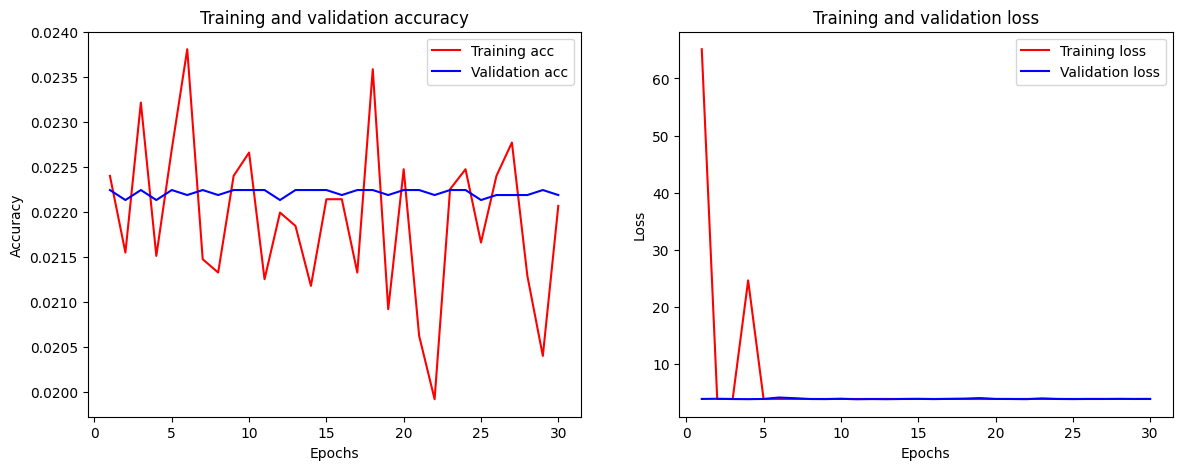

In [30]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Learning rate = 1.0000

In [31]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=1.0000), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,  # 根据需要调整
)

Epoch 1/30
843/843 [==============================] - 467s 551ms/step - loss: 395.2154 - accuracy: 0.0215 - val_loss: 4.1257 - val_accuracy: 0.0222
Epoch 2/30
843/843 [==============================] - 456s 541ms/step - loss: 4.0579 - accuracy: 0.0215 - val_loss: 4.0666 - val_accuracy: 0.0222
Epoch 3/30
843/843 [==============================] - 454s 539ms/step - loss: 4.0787 - accuracy: 0.0214 - val_loss: 4.0768 - val_accuracy: 0.0222
Epoch 4/30
843/843 [==============================] - 457s 542ms/step - loss: 4.0707 - accuracy: 0.0227 - val_loss: 4.0909 - val_accuracy: 0.0222
Epoch 5/30
843/843 [==============================] - 457s 542ms/step - loss: 4.0733 - accuracy: 0.0220 - val_loss: 4.0538 - val_accuracy: 0.0222
Epoch 6/30
843/843 [==============================] - 454s 538ms/step - loss: 4.0869 - accuracy: 0.0217 - val_loss: 4.0478 - val_accuracy: 0.0222
Epoch 7/30
843/843 [==============================] - 461s 547ms/step - loss: 4.0761 - accuracy: 0.0225 - val_loss: 4.0576

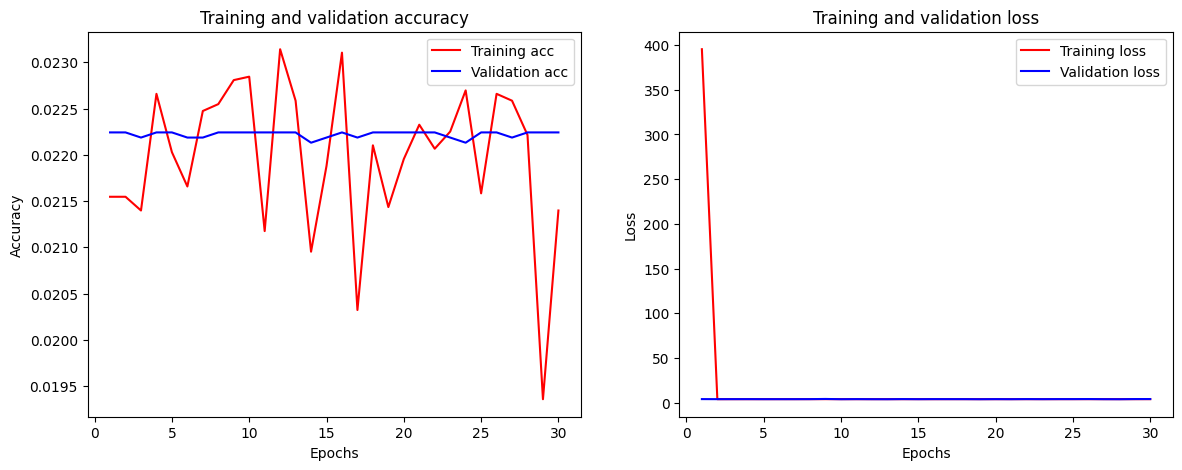

In [33]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Experiment 2: Compare different batch size

| Setting Item        | Value                                        |
|---------------------|----------------------------------------------|
| Train Images        | 26,997 images belonging to 45 classes        |
| Validation Images   | 17,996 images belonging to 45 classes        |
| Input Size          | (256, 256, 3)                                |
| Learning Rate       | 0.0001                                       |
| Epochs              | 30                                           |
| Model               | custom_resnet50 (resnet50+se+dscnn+inception)|
| Optimizer           | Adam                                         |
| Loss                | Categorical Crossentropy                     |

In [3]:
def squeeze_excite_block(input_tensor, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    se_shape = (1, 1, channels)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)

    # 扩展路径1
    se_1 = layers.Dense(channels // reduction_ratio * 2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_1 = layers.Dense(channels // reduction_ratio, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se_1)
    se_1 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_1)

    # 扩展路径2
    se_2 = layers.Dense(channels // reduction_ratio * 4, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_2 = layers.Dropout(0.5)(se_2)
    se_2 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_2)

    se = layers.add([se_1, se_2])
    return layers.multiply([input_tensor, se])

def identity_block(input_tensor, kernel_size, filters, stage, block, ratio=16):
    """A block that has no conv layer at shortcut, with an SE block."""
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = squeeze_excite_block(x, ratio)  # Add SE block

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), ratio=16):
    """A block that has a conv layer at shortcut, with an SE block."""
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = squeeze_excite_block(x, ratio)  # Add SE block

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x
    
def residual_inception_block(input_tensor, filters):
    # 分支1：1x1卷积
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)

    # 分支2：1x1卷积后接3x3卷积
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)

    # 分支3：1x1卷积后接5x5卷积
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)

    # 分支4：3x3最大池化后接1x1卷积
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)

    # 合并所有分支
    x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)

    # 残差连接
    shortcut = layers.Conv2D(4 * filters, (1, 1), strides=(1, 1), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x
    
def depthwise_separable_conv_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=False, reduction_ratio=16):
    # Depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=stride, depth_multiplier=1, padding='same', kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Pointwise convolution
    x = layers.Conv2D(filters, 1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Shortcut path, if required
    if conv_shortcut or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_initializer='he_normal')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    # Apply SE block
    x = squeeze_excite_block(x, reduction_ratio)

    # Combine main path and shortcut
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x
    
# Building ResNet-50
def custom_resnet50_3(input_shape=(256, 256, 3), num_classes=45):
    img_input = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), ratio=16)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', ratio=16)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', ratio=16)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', ratio=16)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', ratio=16)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', ratio=16)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', ratio=16)

    x = residual_inception_block(x, 512)

    x = depthwise_separable_conv_block(x, 1024, kernel_size=3, stride=1, conv_shortcut=True, reduction_ratio=16)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', ratio=16)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', ratio=16)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', ratio=16)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', ratio=16)

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='fc1000')(x)

    model = models.Model(img_input, x)
    return model




In [4]:
def monitor_gpu_memory(interval=5):
    try:
        while True:
            result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv'], stdout=subprocess.PIPE)
            print(result.stdout.decode('utf-8'))
            time.sleep(interval)
    except KeyboardInterrupt:
        print("Stopped monitoring.")

## Batch size= 2

In [7]:
dataset_path =  'E:\Download\JPEGImages (2)\JPEGImages (2)\dataset'
num_classes=45
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # 随机旋转度数范围
    width_shift_range=0.2, # 随机水平移动比例范围
    height_shift_range=0.2, # 随机竖直移动比例范围
    shear_range=0.2, # 剪切变换的程度
    zoom_range=0.2, # 随机缩放的范围
    horizontal_flip=True, # 随机水平翻转
    brightness_range=[0.8, 1.2], # 随机亮度变换的范围
    fill_mode='nearest', # 填充新创建像素的方法
    validation_split=0.4 # 40% 用于验证
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=2,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=2,
    class_mode='categorical',
    subset='validation')

Found 26997 images belonging to 45 classes.
Found 17996 images belonging to 45 classes.


In [8]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
class GPUMemoryMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv'], capture_output=True, text=True)
        print(f"After epoch {epoch+1}, GPU Memory Usage:")
        print(result.stdout)
        
if __name__ == "__main__":
    # 创建GPU监控回调
    gpu_monitor = GPUMemoryMonitor()

    # 配置和编译模型
    model = custom_resnet50_3(input_shape=(256, 256, 3), num_classes=45)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # 进行模型训练
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=30,
        callbacks=[gpu_monitor]  # 添加自定义回调
    )
    # 模型训练完成后，确保监控线程可以优雅退出
    monitor_thread.join()

Epoch 1/30
13497/13498 [============================>.] - ETA: 0s - loss: 3.6403 - accuracy: 0.0658After epoch 1, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15558 MiB, 16376 MiB

13498/13498 [==============================] - 440s 32ms/step - loss: 3.6402 - accuracy: 0.0658 - val_loss: 3.7564 - val_accuracy: 0.1146
Epoch 2/30
13497/13498 [============================>.] - ETA: 0s - loss: 2.8329 - accuracy: 0.2487After epoch 2, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15513 MiB, 16376 MiB

13498/13498 [==============================] - 431s 32ms/step - loss: 2.8331 - accuracy: 0.2487 - val_loss: 2.5002 - val_accuracy: 0.3499
Epoch 3/30
13498/13498 [==============================] - ETA: 0s - loss: 2.0583 - accuracy: 0.4408After epoch 3, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15528 MiB, 16376 MiB

13498/13498 [==============================] - 430s 32ms/step - loss: 2.0583 - accuracy: 0.4408 - val_loss: 2.0783 - val_accuracy: 0.4854
Epoch 4/30

NameError: name 'monitor_thread' is not defined

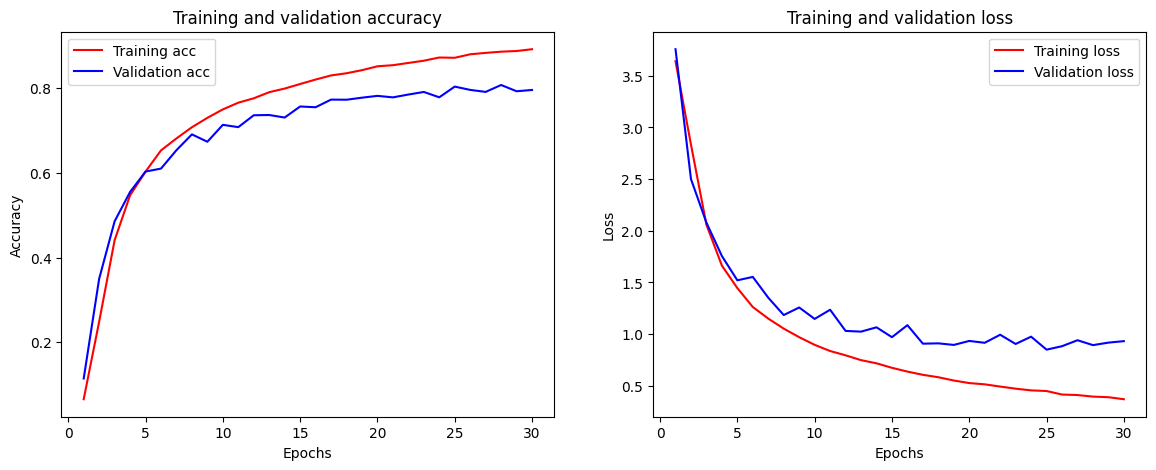

In [9]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Batch size= 4

In [9]:
dataset_path =  'E:\Download\JPEGImages (2)\JPEGImages (2)\dataset'
num_classes=45
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # 随机旋转度数范围
    width_shift_range=0.2, # 随机水平移动比例范围
    height_shift_range=0.2, # 随机竖直移动比例范围
    shear_range=0.2, # 剪切变换的程度
    zoom_range=0.2, # 随机缩放的范围
    horizontal_flip=True, # 随机水平翻转
    brightness_range=[0.8, 1.2], # 随机亮度变换的范围
    fill_mode='nearest', # 填充新创建像素的方法
    validation_split=0.4 # 40% 用于验证
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=4,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=4,
    class_mode='categorical',
    subset='validation')

Found 26997 images belonging to 45 classes.
Found 17996 images belonging to 45 classes.


In [10]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
class GPUMemoryMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv'], capture_output=True, text=True)
        print(f"After epoch {epoch+1}, GPU Memory Usage:")
        print(result.stdout)
        
if __name__ == "__main__":
    gpu_monitor = GPUMemoryMonitor()

    model = custom_resnet50_3(input_shape=(256, 256, 3), num_classes=45)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=30,
        callbacks=[gpu_monitor] 
    )
    

Epoch 1/30
6748/6749 [============================>.] - ETA: 0s - loss: 3.1344 - accuracy: 0.1981After epoch 1, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15170 MiB, 16376 MiB

6749/6749 [==============================] - 516s 76ms/step - loss: 3.1342 - accuracy: 0.1981 - val_loss: 2.3578 - val_accuracy: 0.3947
Epoch 2/30
6749/6749 [==============================] - ETA: 0s - loss: 1.8472 - accuracy: 0.5063After epoch 2, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15204 MiB, 16376 MiB

6749/6749 [==============================] - 497s 74ms/step - loss: 1.8472 - accuracy: 0.5063 - val_loss: 1.7342 - val_accuracy: 0.5560
Epoch 3/30
6748/6749 [============================>.] - ETA: 0s - loss: 1.4013 - accuracy: 0.6174After epoch 3, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15205 MiB, 16376 MiB

6749/6749 [==============================] - 445s 66ms/step - loss: 1.4012 - accuracy: 0.6175 - val_loss: 1.4134 - val_accuracy: 0.6264
Epoch 4/30
6748/6749 [

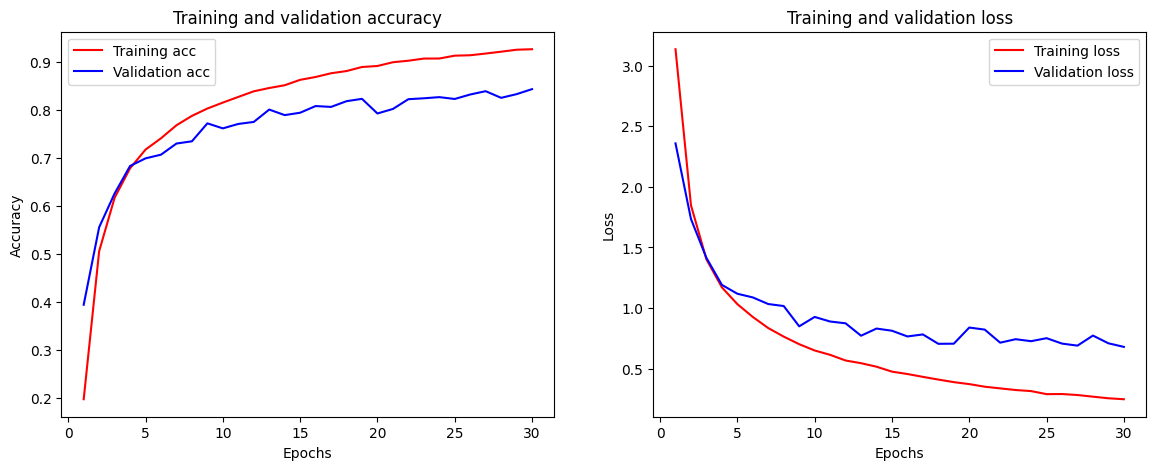

In [12]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Batch size= 8

In [13]:
dataset_path =  'E:\Download\JPEGImages (2)\JPEGImages (2)\dataset'
num_classes=45
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # 随机旋转度数范围
    width_shift_range=0.2, # 随机水平移动比例范围
    height_shift_range=0.2, # 随机竖直移动比例范围
    shear_range=0.2, # 剪切变换的程度
    zoom_range=0.2, # 随机缩放的范围
    horizontal_flip=True, # 随机水平翻转
    brightness_range=[0.8, 1.2], # 随机亮度变换的范围
    fill_mode='nearest', # 填充新创建像素的方法
    validation_split=0.4 # 40% 用于验证
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=8,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=8,
    class_mode='categorical',
    subset='validation')

Found 26997 images belonging to 45 classes.
Found 17996 images belonging to 45 classes.


In [14]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
class GPUMemoryMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv'], capture_output=True, text=True)
        print(f"After epoch {epoch+1}, GPU Memory Usage:")
        print(result.stdout)
        
if __name__ == "__main__":
    gpu_monitor = GPUMemoryMonitor()

    model = custom_resnet50_3(input_shape=(256, 256, 3), num_classes=45)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=30,
        callbacks=[gpu_monitor]  
    )

Epoch 1/30
3374/3374 [==============================] - ETA: 0s - loss: 2.9245 - accuracy: 0.2511After epoch 1, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15582 MiB, 16376 MiB

3374/3374 [==============================] - 457s 135ms/step - loss: 2.9245 - accuracy: 0.2511 - val_loss: 2.2658 - val_accuracy: 0.4179
Epoch 2/30
3374/3374 [==============================] - ETA: 0s - loss: 1.6796 - accuracy: 0.5564After epoch 2, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15627 MiB, 16376 MiB

3374/3374 [==============================] - 452s 134ms/step - loss: 1.6796 - accuracy: 0.5564 - val_loss: 1.5911 - val_accuracy: 0.5781
Epoch 3/30
3374/3374 [==============================] - ETA: 0s - loss: 1.2615 - accuracy: 0.6577After epoch 3, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15601 MiB, 16376 MiB

3374/3374 [==============================] - 529s 157ms/step - loss: 1.2615 - accuracy: 0.6577 - val_loss: 1.2889 - val_accuracy: 0.6567
Epoch 4/30
3374/337

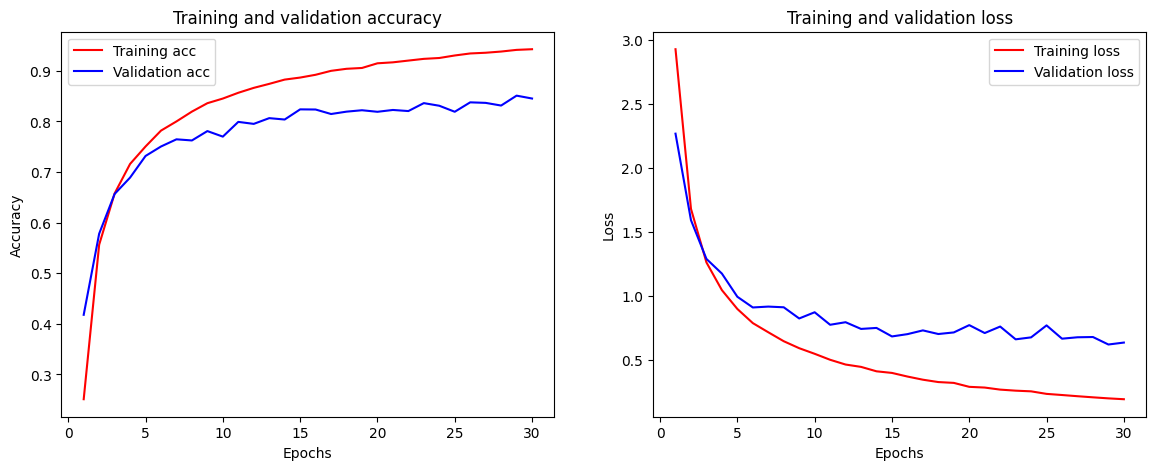

In [16]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Batch size= 16

In [17]:
dataset_path =  'E:\Download\JPEGImages (2)\JPEGImages (2)\dataset'
num_classes=45
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # 随机旋转度数范围
    width_shift_range=0.2, # 随机水平移动比例范围
    height_shift_range=0.2, # 随机竖直移动比例范围
    shear_range=0.2, # 剪切变换的程度
    zoom_range=0.2, # 随机缩放的范围
    horizontal_flip=True, # 随机水平翻转
    brightness_range=[0.8, 1.2], # 随机亮度变换的范围
    fill_mode='nearest', # 填充新创建像素的方法
    validation_split=0.4 # 40% 用于验证
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    subset='validation')

Found 26997 images belonging to 45 classes.
Found 17996 images belonging to 45 classes.


In [18]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
class GPUMemoryMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv'], capture_output=True, text=True)
        print(f"After epoch {epoch+1}, GPU Memory Usage:")
        print(result.stdout)
        
if __name__ == "__main__":
    gpu_monitor = GPUMemoryMonitor()


    model = custom_resnet50_3(input_shape=(256, 256, 3), num_classes=45)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=30,
        callbacks=[gpu_monitor]  
    )

Epoch 1/30
1687/1687 [==============================] - ETA: 0s - loss: 2.7608 - accuracy: 0.2957After epoch 1, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15322 MiB, 16376 MiB

1687/1687 [==============================] - 434s 256ms/step - loss: 2.7608 - accuracy: 0.2957 - val_loss: 1.9988 - val_accuracy: 0.4745
Epoch 2/30
1687/1687 [==============================] - ETA: 0s - loss: 1.5912 - accuracy: 0.5787After epoch 2, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15330 MiB, 16376 MiB

1687/1687 [==============================] - 434s 257ms/step - loss: 1.5912 - accuracy: 0.5787 - val_loss: 1.8986 - val_accuracy: 0.5175
Epoch 3/30
1687/1687 [==============================] - ETA: 0s - loss: 1.2126 - accuracy: 0.6714After epoch 3, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15354 MiB, 16376 MiB

1687/1687 [==============================] - 442s 262ms/step - loss: 1.2126 - accuracy: 0.6714 - val_loss: 1.2800 - val_accuracy: 0.6533
Epoch 4/30
1687/168

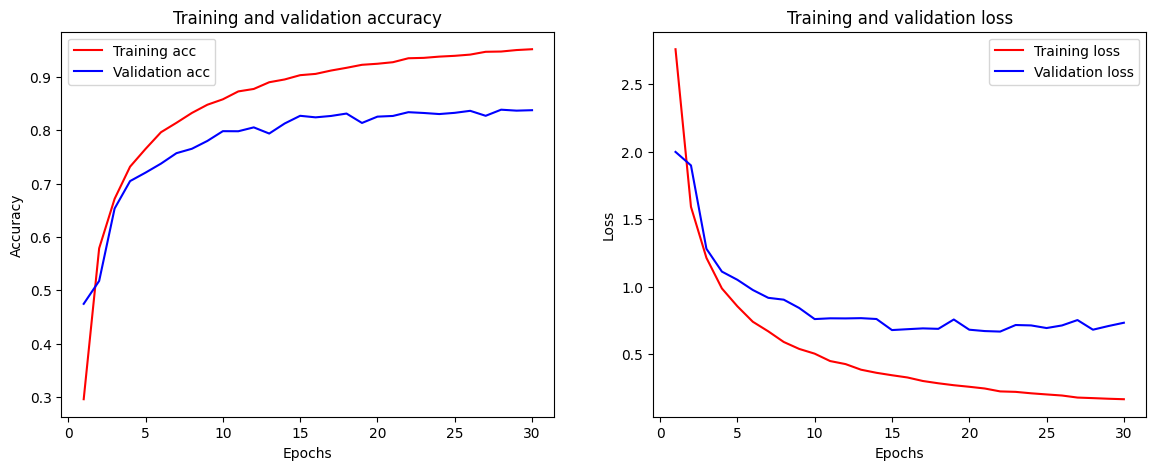

In [20]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Batch size= 32

In [21]:
dataset_path =  'E:\Download\JPEGImages (2)\JPEGImages (2)\dataset'
num_classes=45
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # 随机旋转度数范围
    width_shift_range=0.2, # 随机水平移动比例范围
    height_shift_range=0.2, # 随机竖直移动比例范围
    shear_range=0.2, # 剪切变换的程度
    zoom_range=0.2, # 随机缩放的范围
    horizontal_flip=True, # 随机水平翻转
    brightness_range=[0.8, 1.2], # 随机亮度变换的范围
    fill_mode='nearest', # 填充新创建像素的方法
    validation_split=0.4 # 40% 用于验证
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 26997 images belonging to 45 classes.
Found 17996 images belonging to 45 classes.


In [22]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
class GPUMemoryMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv'], capture_output=True, text=True)
        print(f"After epoch {epoch+1}, GPU Memory Usage:")
        print(result.stdout)
        
if __name__ == "__main__":
    gpu_monitor = GPUMemoryMonitor()


    model = custom_resnet50_3(input_shape=(256, 256, 3), num_classes=45)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=30,
        callbacks=[gpu_monitor]
    )


Epoch 1/30
843/843 [==============================] - ETA: 0s - loss: 2.7742 - accuracy: 0.2934After epoch 1, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15353 MiB, 16376 MiB

843/843 [==============================] - 448s 528ms/step - loss: 2.7742 - accuracy: 0.2934 - val_loss: 2.3546 - val_accuracy: 0.3769
Epoch 2/30
843/843 [==============================] - ETA: 0s - loss: 1.5222 - accuracy: 0.5940After epoch 2, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15364 MiB, 16376 MiB

843/843 [==============================] - 441s 524ms/step - loss: 1.5222 - accuracy: 0.5940 - val_loss: 1.5707 - val_accuracy: 0.5834
Epoch 3/30
843/843 [==============================] - ETA: 0s - loss: 1.1336 - accuracy: 0.6920After epoch 3, GPU Memory Usage:
memory.used [MiB], memory.total [MiB]
15277 MiB, 16376 MiB

843/843 [==============================] - 449s 533ms/step - loss: 1.1336 - accuracy: 0.6920 - val_loss: 1.2357 - val_accuracy: 0.6726
Epoch 4/30
843/843 [===========

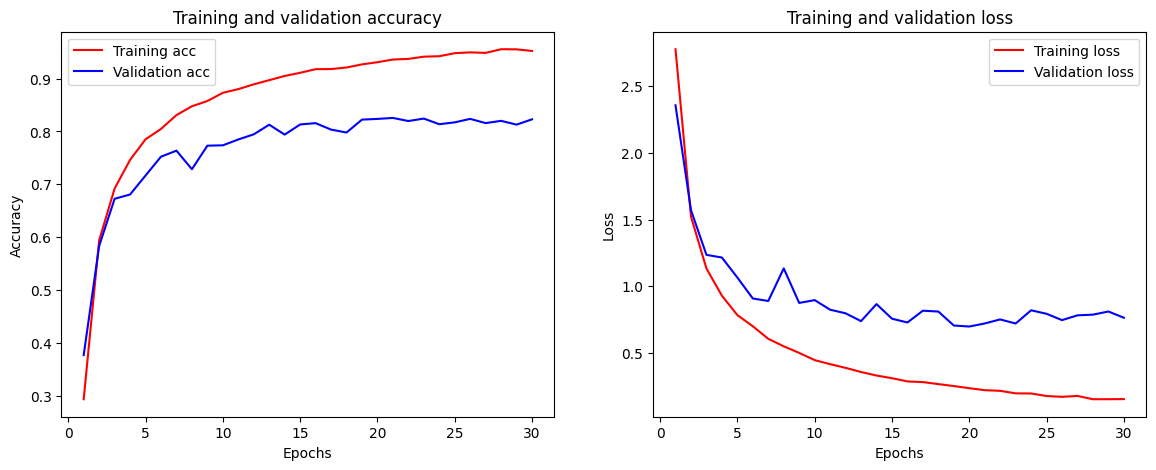

In [24]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Experiment 3: Compare different optimizers

| Setting Item        | Value                                    |
|---------------------|------------------------------------------|
| Train Images        | 26,997 images belonging to 45 classes    |
| Validation Images   | 17,996 images belonging to 45 classes    |
| Input Size          | (256, 256, 3)                            |
| Model               | custom_resnet50 (resnet50+se+dscnn+inception) |
| Epochs              | 30                                       |
| Batch Size          | 32                                       |
| Learning Rate       | 0.0001                                   |
| Loss                | Categorical Crossentropy                 |

In [5]:
def squeeze_excite_block(input_tensor, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    se_shape = (1, 1, channels)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)

    # 扩展路径1
    se_1 = layers.Dense(channels // reduction_ratio * 2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_1 = layers.Dense(channels // reduction_ratio, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se_1)
    se_1 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_1)

    # 扩展路径2
    se_2 = layers.Dense(channels // reduction_ratio * 4, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_2 = layers.Dropout(0.5)(se_2)
    se_2 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_2)

    se = layers.add([se_1, se_2])
    return layers.multiply([input_tensor, se])

def identity_block(input_tensor, kernel_size, filters, stage, block, ratio=16):
    """A block that has no conv layer at shortcut, with an SE block."""
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = squeeze_excite_block(x, ratio)  # Add SE block

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), ratio=16):
    """A block that has a conv layer at shortcut, with an SE block."""
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = squeeze_excite_block(x, ratio)  # Add SE block

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x
    
def residual_inception_block(input_tensor, filters):
    # 分支1：1x1卷积
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)

    # 分支2：1x1卷积后接3x3卷积
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)

    # 分支3：1x1卷积后接5x5卷积
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)

    # 分支4：3x3最大池化后接1x1卷积
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)

    # 合并所有分支
    x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)

    # 残差连接
    shortcut = layers.Conv2D(4 * filters, (1, 1), strides=(1, 1), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x
    
def depthwise_separable_conv_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=False, reduction_ratio=16):
    # Depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=stride, depth_multiplier=1, padding='same', kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Pointwise convolution
    x = layers.Conv2D(filters, 1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Shortcut path, if required
    if conv_shortcut or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_initializer='he_normal')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    # Apply SE block
    x = squeeze_excite_block(x, reduction_ratio)

    # Combine main path and shortcut
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x
    
# Building ResNet-50
def custom_resnet50_3(input_shape=(256, 256, 3), num_classes=45):
    img_input = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), ratio=16)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', ratio=16)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', ratio=16)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', ratio=16)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', ratio=16)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', ratio=16)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', ratio=16)

    x = residual_inception_block(x, 512)

    x = depthwise_separable_conv_block(x, 1024, kernel_size=3, stride=1, conv_shortcut=True, reduction_ratio=16)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', ratio=16)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', ratio=16)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', ratio=16)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', ratio=16)

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='fc1000')(x)

    model = models.Model(img_input, x)
    return model




## Adam

In [7]:
# Create the model
model = custom_resnet50_3()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30, 
)

Epoch 1/30
843/843 [==============================] - 446s 525ms/step - loss: 2.7219 - accuracy: 0.3026 - val_loss: 2.4908 - val_accuracy: 0.4035
Epoch 2/30
843/843 [==============================] - 442s 525ms/step - loss: 1.5052 - accuracy: 0.5985 - val_loss: 1.4570 - val_accuracy: 0.6166
Epoch 3/30
843/843 [==============================] - 440s 522ms/step - loss: 1.1203 - accuracy: 0.6958 - val_loss: 1.2328 - val_accuracy: 0.6663
Epoch 4/30
843/843 [==============================] - 442s 524ms/step - loss: 0.9239 - accuracy: 0.7466 - val_loss: 1.0533 - val_accuracy: 0.7173
Epoch 5/30
843/843 [==============================] - 445s 528ms/step - loss: 0.7915 - accuracy: 0.7800 - val_loss: 1.0022 - val_accuracy: 0.7319
Epoch 6/30
843/843 [==============================] - 445s 528ms/step - loss: 0.6774 - accuracy: 0.8123 - val_loss: 1.0758 - val_accuracy: 0.7172
Epoch 7/30
843/843 [==============================] - 442s 525ms/step - loss: 0.6104 - accuracy: 0.8281 - val_loss: 1.1384 -

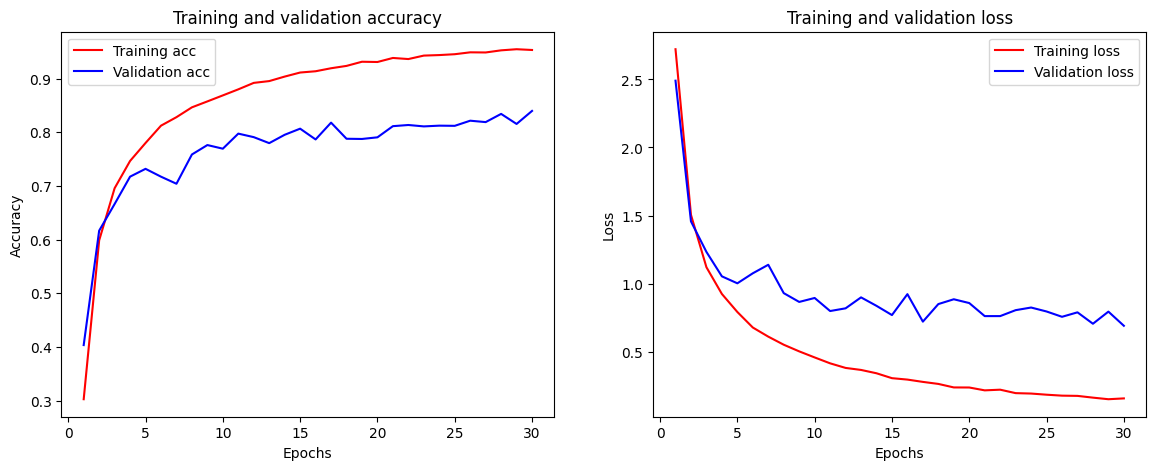

In [9]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## SDG

In [6]:
from tensorflow.keras.optimizers import SGD

# Create the model
model = custom_resnet50_3()
model.compile(optimizer=SGD(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30, 
)

Epoch 1/30
843/843 [==============================] - 557s 648ms/step - loss: 5.9154 - accuracy: 0.0236 - val_loss: 5.8071 - val_accuracy: 0.0235
Epoch 2/30
843/843 [==============================] - 432s 512ms/step - loss: 5.7963 - accuracy: 0.0239 - val_loss: 5.8298 - val_accuracy: 0.0238
Epoch 3/30
843/843 [==============================] - 435s 516ms/step - loss: 5.7905 - accuracy: 0.0250 - val_loss: 5.8025 - val_accuracy: 0.0257
Epoch 4/30
843/843 [==============================] - 434s 514ms/step - loss: 5.7878 - accuracy: 0.0244 - val_loss: 5.7855 - val_accuracy: 0.0274
Epoch 5/30
843/843 [==============================] - 438s 519ms/step - loss: 5.7822 - accuracy: 0.0294 - val_loss: 5.7896 - val_accuracy: 0.0291
Epoch 6/30
843/843 [==============================] - 441s 523ms/step - loss: 5.7815 - accuracy: 0.0276 - val_loss: 5.7820 - val_accuracy: 0.0284
Epoch 7/30
843/843 [==============================] - 441s 523ms/step - loss: 5.7814 - accuracy: 0.0270 - val_loss: 5.7844 -

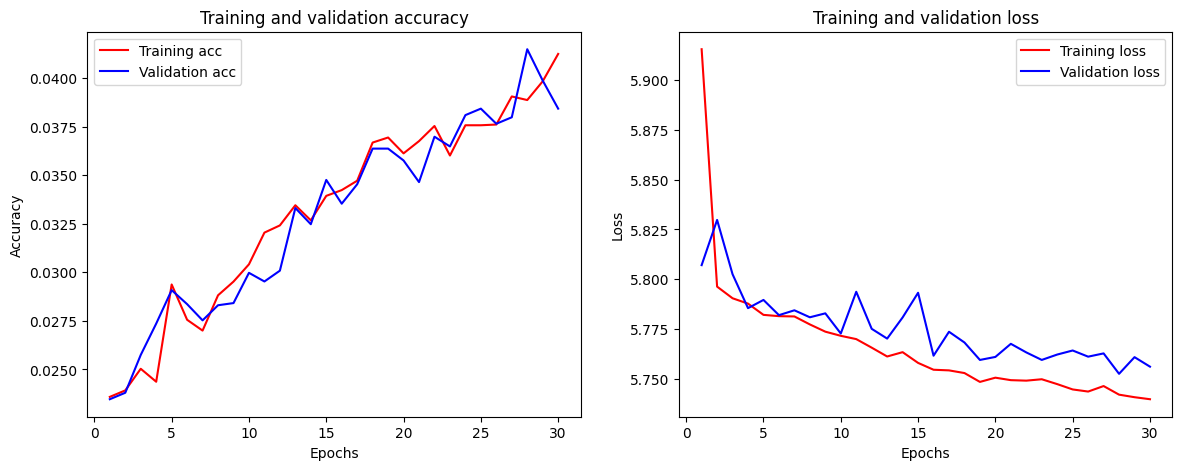

In [8]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Rmsprop

In [9]:
from tensorflow.keras.optimizers import RMSprop

# Create the model
model = custom_resnet50_3()
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30, 
)

Epoch 1/30
843/843 [==============================] - 462s 535ms/step - loss: 5.5412 - accuracy: 0.0340 - val_loss: 7.5059 - val_accuracy: 0.0291
Epoch 2/30
843/843 [==============================] - 453s 537ms/step - loss: 4.5472 - accuracy: 0.0673 - val_loss: 4.4230 - val_accuracy: 0.0626
Epoch 3/30
843/843 [==============================] - 451s 535ms/step - loss: 3.7543 - accuracy: 0.1335 - val_loss: 3.7815 - val_accuracy: 0.1227
Epoch 4/30
843/843 [==============================] - 451s 534ms/step - loss: 3.2913 - accuracy: 0.2075 - val_loss: 3.6444 - val_accuracy: 0.1448
Epoch 5/30
843/843 [==============================] - 449s 532ms/step - loss: 2.8897 - accuracy: 0.2894 - val_loss: 3.1860 - val_accuracy: 0.2271
Epoch 6/30
843/843 [==============================] - 450s 533ms/step - loss: 2.5532 - accuracy: 0.3633 - val_loss: 3.1601 - val_accuracy: 0.2610
Epoch 7/30
843/843 [==============================] - 447s 530ms/step - loss: 2.2893 - accuracy: 0.4236 - val_loss: 2.9385 -

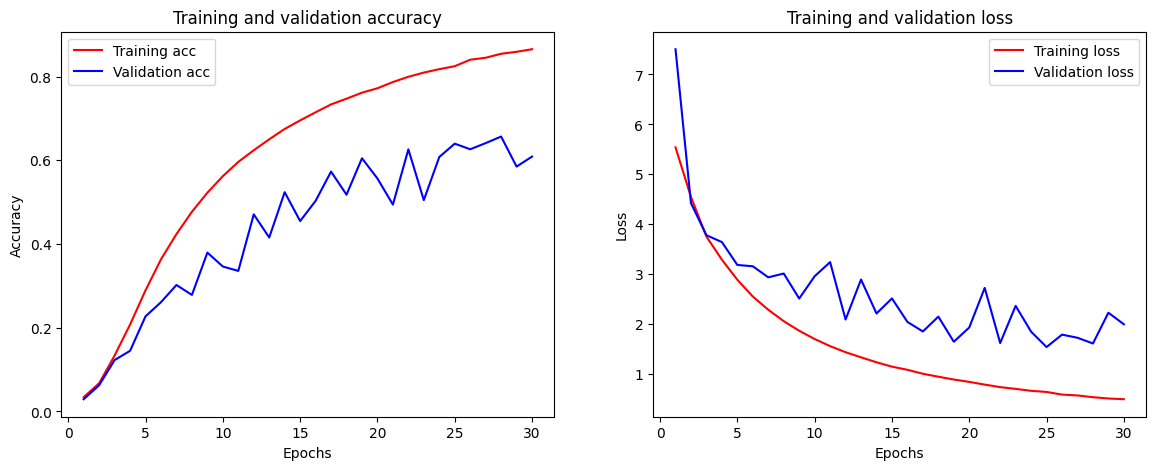

In [11]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


#  Experiment 4: Compare different model

| Setting Item        | Value                                    |
|---------------------|------------------------------------------|
| Train Images        | 26,997 images belonging to 45 classes    |
| Validation Images   | 17,996 images belonging to 45 classes    |
| Input Size          | (256, 256, 3)                            |
| Learning Rate       | 0.0001                                   |
| Epochs              | 30                                       |
| Batch Size          | 32                                       |
| Optimizer           | Adam                                     |
| Loss                | Categorical Crossentropy                 |


## CNN

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(input_shape, num_classes):
    model = Sequential([
        # 第一个卷积层, 32个3x3的卷积核
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        # 第二个卷积层, 64个3x3的卷积核
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        # 第三个卷积层, 128个3x3的卷积核
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        # 展平层，将3D特征转换为1D特征向量
        Flatten(),
        # 全连接层
        Dense(512, activation='relu'),
        # Dropout层，防止过拟合
        Dropout(0.5),
        # 输出层
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


input_shape = (256, 256, 3) 
num_classes = 45 
model = build_model(input_shape, num_classes)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [6]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,  # 根据需要调整
)

Epoch 1/30
843/843 [==============================] - 563s 667ms/step - loss: 3.7979 - accuracy: 0.0325 - val_loss: 3.7654 - val_accuracy: 0.0492
Epoch 2/30
843/843 [==============================] - 436s 517ms/step - loss: 3.7511 - accuracy: 0.0474 - val_loss: 3.7188 - val_accuracy: 0.0587
Epoch 3/30
843/843 [==============================] - 437s 519ms/step - loss: 3.7130 - accuracy: 0.0578 - val_loss: 3.6935 - val_accuracy: 0.0652
Epoch 4/30
843/843 [==============================] - 432s 513ms/step - loss: 3.6706 - accuracy: 0.0671 - val_loss: 3.6517 - val_accuracy: 0.0746
Epoch 5/30
843/843 [==============================] - 443s 526ms/step - loss: 3.6396 - accuracy: 0.0726 - val_loss: 3.6165 - val_accuracy: 0.0820
Epoch 6/30
843/843 [==============================] - 442s 525ms/step - loss: 3.6097 - accuracy: 0.0833 - val_loss: 3.6032 - val_accuracy: 0.0835
Epoch 7/30
843/843 [==============================] - 446s 529ms/step - loss: 3.5831 - accuracy: 0.0898 - val_loss: 3.5824 -

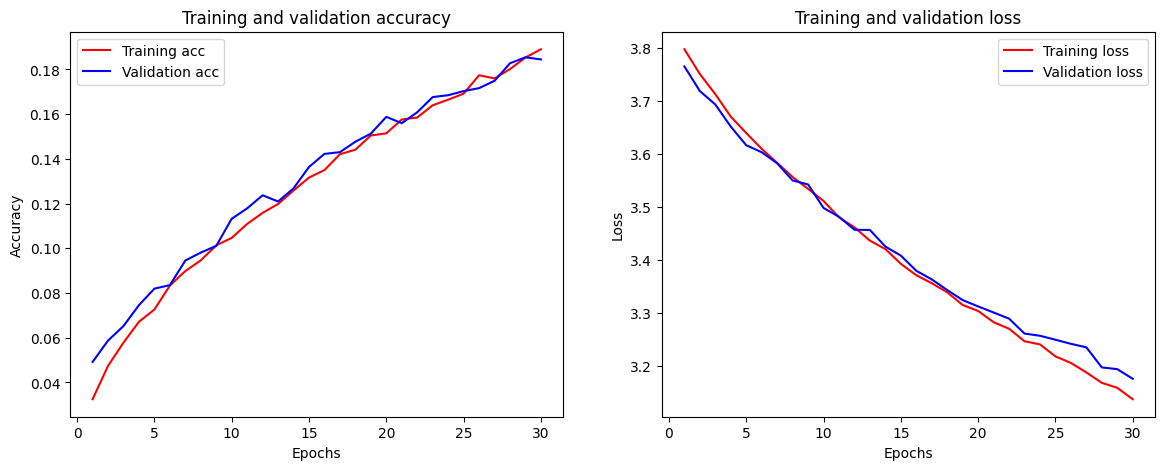

In [8]:
import matplotlib.pyplot as plt

# 假设 history.history 包含了训练集和验证集的准确率和损失值
# 使用 matplotlib 绘制训练和验证的准确率以及损失值

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 绘制训练和验证的准确率
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 绘制训练和验证的损失值
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## ResNet50

In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))

In [35]:
num_classes = len(train_generator.class_indices)

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [36]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30, 
)
model.save('resnet50.h5')

Epoch 1/30
843/843 [==============================] - 459s 537ms/step - loss: 4.0083 - accuracy: 0.0484 - val_loss: 3.9706 - val_accuracy: 0.0452
Epoch 2/30
843/843 [==============================] - 455s 540ms/step - loss: 3.7171 - accuracy: 0.0845 - val_loss: 3.8615 - val_accuracy: 0.0587
Epoch 3/30
843/843 [==============================] - 455s 540ms/step - loss: 3.5112 - accuracy: 0.1227 - val_loss: 3.6901 - val_accuracy: 0.1040
Epoch 4/30
843/843 [==============================] - 456s 541ms/step - loss: 3.3126 - accuracy: 0.1663 - val_loss: 3.8395 - val_accuracy: 0.1148
Epoch 5/30
843/843 [==============================] - 456s 540ms/step - loss: 3.0915 - accuracy: 0.2170 - val_loss: 3.2162 - val_accuracy: 0.1985
Epoch 6/30
843/843 [==============================] - 458s 544ms/step - loss: 2.8451 - accuracy: 0.2769 - val_loss: 3.0716 - val_accuracy: 0.2413
Epoch 7/30
843/843 [==============================] - 459s 544ms/step - loss: 2.6236 - accuracy: 0.3271 - val_loss: 2.9037 -

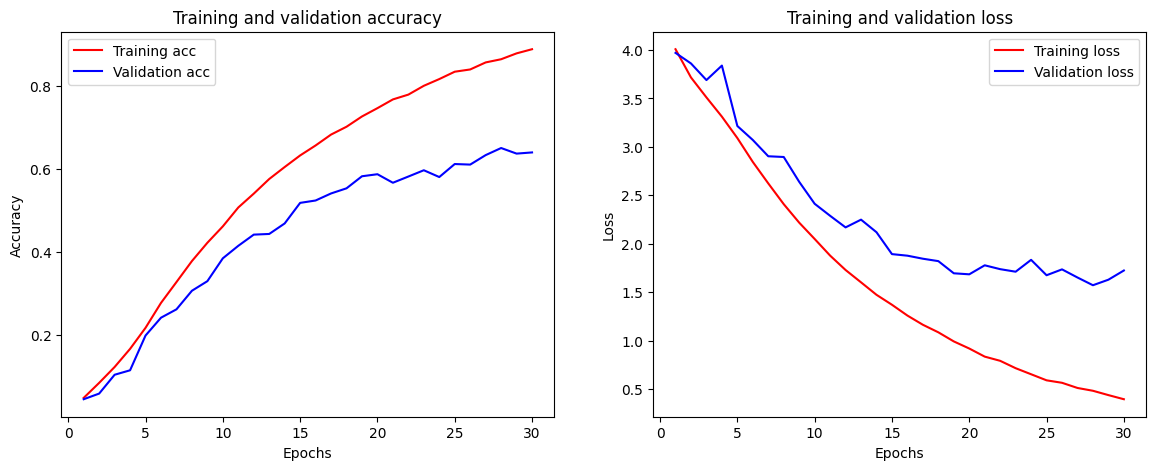

In [37]:
import matplotlib.pyplot as plt

# 假设 history.history 包含了训练集和验证集的准确率和损失值
# 使用 matplotlib 绘制训练和验证的准确率以及损失值

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 绘制训练和验证的准确率
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 绘制训练和验证的损失值
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Custom model(resnet50+se)

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, regularizers

# 定义你的 Squeeze-and-Excite block
def squeeze_excite_block(input_tensor, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    se_shape = (1, 1, channels)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)

    # 扩展路径1
    se_1 = layers.Dense(channels // reduction_ratio * 2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_1 = layers.Dense(channels // reduction_ratio, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se_1)
    se_1 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_1)

    # 扩展路径2
    se_2 = layers.Dense(channels // reduction_ratio * 4, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_2 = layers.Dropout(0.5)(se_2)
    se_2 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_2)

    se = layers.add([se_1, se_2])
    return layers.multiply([input_tensor, se])

def identity_block(input_tensor, kernel_size, filters, stage, block, ratio=16):
    """A block that has no conv layer at shortcut, with an SE block."""
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = squeeze_excite_block(x, ratio)  # Add SE block

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), ratio=16):
    """A block that has a conv layer at shortcut, with an SE block."""
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = squeeze_excite_block(x, ratio)  # Add SE block

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x
def custom_resnet50(input_shape=(224, 224, 3), num_classes=1000):
    img_input = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='fc1000')(x)

    # Create model.
    model = models.Model(img_input, x)
    return model





# 创建并查看自定义模型
model = custom_resnet50(input_shape=(256, 256, 3), num_classes=45)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_6[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,  # 根据需要调整
)
model.save('resnet50withsedemo.h5')

Epoch 1/30
843/843 [==============================] - 561s 657ms/step - loss: 5.4796 - accuracy: 0.0381 - val_loss: 5.5326 - val_accuracy: 0.0385
Epoch 2/30
843/843 [==============================] - 454s 538ms/step - loss: 4.8211 - accuracy: 0.0681 - val_loss: 4.7821 - val_accuracy: 0.0720
Epoch 3/30
843/843 [==============================] - 453s 537ms/step - loss: 4.2690 - accuracy: 0.1085 - val_loss: 4.2321 - val_accuracy: 0.1051
Epoch 4/30
843/843 [==============================] - 457s 542ms/step - loss: 3.7869 - accuracy: 0.1575 - val_loss: 4.0198 - val_accuracy: 0.1268
Epoch 5/30
843/843 [==============================] - 469s 557ms/step - loss: 3.3953 - accuracy: 0.2138 - val_loss: 3.7505 - val_accuracy: 0.1465
Epoch 6/30
843/843 [==============================] - 453s 538ms/step - loss: 3.0720 - accuracy: 0.2632 - val_loss: 3.7197 - val_accuracy: 0.1488
Epoch 7/30
843/843 [==============================] - 463s 550ms/step - loss: 2.7776 - accuracy: 0.3260 - val_loss: 3.3075 -

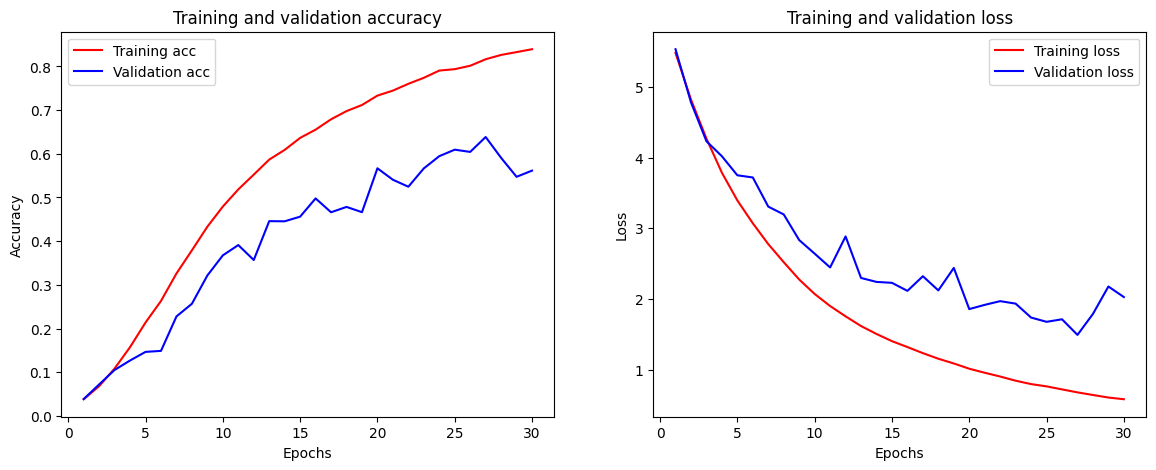

In [22]:
import matplotlib.pyplot as plt

# 假设 history.history 包含了训练集和验证集的准确率和损失值
# 使用 matplotlib 绘制训练和验证的准确率以及损失值

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 绘制训练和验证的准确率
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 绘制训练和验证的损失值
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Custom model(resnet50+se+inception)

In [23]:
def squeeze_excite_block(input_tensor, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    se_shape = (1, 1, channels)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)

    # 扩展路径1
    se_1 = layers.Dense(channels // reduction_ratio * 2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_1 = layers.Dense(channels // reduction_ratio, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se_1)
    se_1 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_1)

    # 扩展路径2
    se_2 = layers.Dense(channels // reduction_ratio * 4, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_2 = layers.Dropout(0.5)(se_2)
    se_2 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_2)

    se = layers.add([se_1, se_2])
    return layers.multiply([input_tensor, se])

def identity_block(input_tensor, kernel_size, filters, stage, block, ratio=16):
    """A block that has no conv layer at shortcut, with an SE block."""
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = squeeze_excite_block(x, ratio)  # Add SE block

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), ratio=16):
    """A block that has a conv layer at shortcut, with an SE block."""
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = squeeze_excite_block(x, ratio)  # Add SE block

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x
    
def residual_inception_block(input_tensor, filters):
    # 分支1：1x1卷积
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)

    # 分支2：1x1卷积后接3x3卷积
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)

    # 分支3：1x1卷积后接5x5卷积
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)

    # 分支4：3x3最大池化后接1x1卷积
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)

    # 合并所有分支
    x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)

    # 残差连接
    shortcut = layers.Conv2D(4 * filters, (1, 1), strides=(1, 1), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

# Building ResNet-50
def custom_resnet50_2(input_shape=(256, 256, 3), num_classes=45):
    img_input = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # 同前定义的ResNet blocks
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = residual_inception_block(x, 256)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='fc1000')(x)

    # 创建模型
    model = models.Model(img_input, x)
    return model


# Create the model
model = custom_resnet50_2()

In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# 查看模型结构
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_7[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 128, 64  9472        ['zero_padding2d_3[0][0]']       
                                )                                                           

In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,  # 根据需要调整
)
model.save('resnet50withseinceptiondemo.h5')

Epoch 1/30
843/843 [==============================] - 458s 534ms/step - loss: 5.4773 - accuracy: 0.0389 - val_loss: 6.0567 - val_accuracy: 0.0334
Epoch 2/30
843/843 [==============================] - 451s 535ms/step - loss: 4.8173 - accuracy: 0.0711 - val_loss: 4.9158 - val_accuracy: 0.0537
Epoch 3/30
843/843 [==============================] - 451s 535ms/step - loss: 4.2538 - accuracy: 0.1126 - val_loss: 4.2610 - val_accuracy: 0.0971
Epoch 4/30
843/843 [==============================] - 445s 528ms/step - loss: 3.7542 - accuracy: 0.1656 - val_loss: 4.0663 - val_accuracy: 0.1119
Epoch 5/30
843/843 [==============================] - 453s 537ms/step - loss: 3.3288 - accuracy: 0.2284 - val_loss: 3.8257 - val_accuracy: 0.1629
Epoch 6/30
843/843 [==============================] - 460s 545ms/step - loss: 2.9846 - accuracy: 0.2861 - val_loss: 3.3748 - val_accuracy: 0.1950
Epoch 7/30
843/843 [==============================] - 454s 538ms/step - loss: 2.6656 - accuracy: 0.3532 - val_loss: 2.9345 -

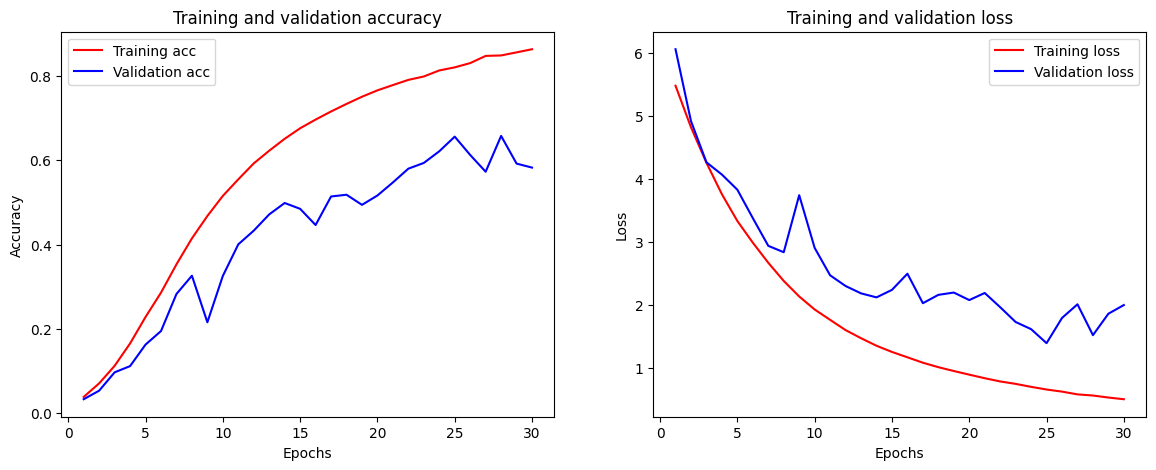

In [26]:
import matplotlib.pyplot as plt

# 假设 history.history 包含了训练集和验证集的准确率和损失值
# 使用 matplotlib 绘制训练和验证的准确率以及损失值

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 绘制训练和验证的准确率
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 绘制训练和验证的损失值
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## custom_resnet_combine

In [7]:
def squeeze_excite_block(input_tensor, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    se_shape = (1, 1, channels)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)

    # 扩展路径1
    se_1 = layers.Dense(channels // reduction_ratio * 2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_1 = layers.Dense(channels // reduction_ratio, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se_1)
    se_1 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_1)

    # 扩展路径2
    se_2 = layers.Dense(channels // reduction_ratio * 4, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_2 = layers.Dropout(0.5)(se_2)
    se_2 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_2)

    se = layers.add([se_1, se_2])
    return layers.multiply([input_tensor, se])

def identity_block(input_tensor, kernel_size, filters, stage, block, ratio=16):
    """A block that has no conv layer at shortcut, with an SE block."""
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = squeeze_excite_block(x, ratio)  # Add SE block

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), ratio=16):
    """A block that has a conv layer at shortcut, with an SE block."""
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = squeeze_excite_block(x, ratio)  # Add SE block

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x
    
def residual_inception_block(input_tensor, filters):
    # 分支1：1x1卷积
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)

    # 分支2：1x1卷积后接3x3卷积
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)

    # 分支3：1x1卷积后接5x5卷积
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)

    # 分支4：3x3最大池化后接1x1卷积
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)

    # 合并所有分支
    x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)

    # 残差连接
    shortcut = layers.Conv2D(4 * filters, (1, 1), strides=(1, 1), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x
    
def depthwise_separable_conv_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=False, reduction_ratio=16):
    # Depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=stride, depth_multiplier=1, padding='same', kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Pointwise convolution
    x = layers.Conv2D(filters, 1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Shortcut path, if required
    if conv_shortcut or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_initializer='he_normal')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    # Apply SE block
    x = squeeze_excite_block(x, reduction_ratio)

    # Combine main path and shortcut
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x
    
# Building ResNet-50
def custom_resnet50_3(input_shape=(256, 256, 3), num_classes=45):
    img_input = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), ratio=16)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', ratio=16)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', ratio=16)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', ratio=16)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', ratio=16)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', ratio=16)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', ratio=16)

    x = residual_inception_block(x, 512)

    x = depthwise_separable_conv_block(x, 1024, kernel_size=3, stride=1, conv_shortcut=True, reduction_ratio=16)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', ratio=16)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', ratio=16)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', ratio=16)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', ratio=16)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', ratio=16)

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='fc1000')(x)

    model = models.Model(img_input, x)
    return model


# Create the model
model = custom_resnet50_3()

In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,  # 根据需要调整
)
model.save('resnet50combinedemo.h5')

Epoch 1/30
843/843 [==============================] - 467s 542ms/step - loss: 5.5883 - accuracy: 0.0364 - val_loss: 5.6539 - val_accuracy: 0.0421
Epoch 2/30
843/843 [==============================] - 545s 646ms/step - loss: 4.9443 - accuracy: 0.0670 - val_loss: 4.8244 - val_accuracy: 0.0631
Epoch 3/30
843/843 [==============================] - 441s 524ms/step - loss: 4.3904 - accuracy: 0.1022 - val_loss: 4.3315 - val_accuracy: 0.1014
Epoch 4/30
843/843 [==============================] - 450s 533ms/step - loss: 3.9043 - accuracy: 0.1466 - val_loss: 4.1654 - val_accuracy: 0.0970
Epoch 5/30
843/843 [==============================] - 459s 544ms/step - loss: 3.4819 - accuracy: 0.2011 - val_loss: 3.7873 - val_accuracy: 0.1552
Epoch 6/30
843/843 [==============================] - 444s 526ms/step - loss: 3.1219 - accuracy: 0.2661 - val_loss: 3.6731 - val_accuracy: 0.1849
Epoch 7/30
843/843 [==============================] - 442s 525ms/step - loss: 2.7963 - accuracy: 0.3226 - val_loss: 3.4698 -

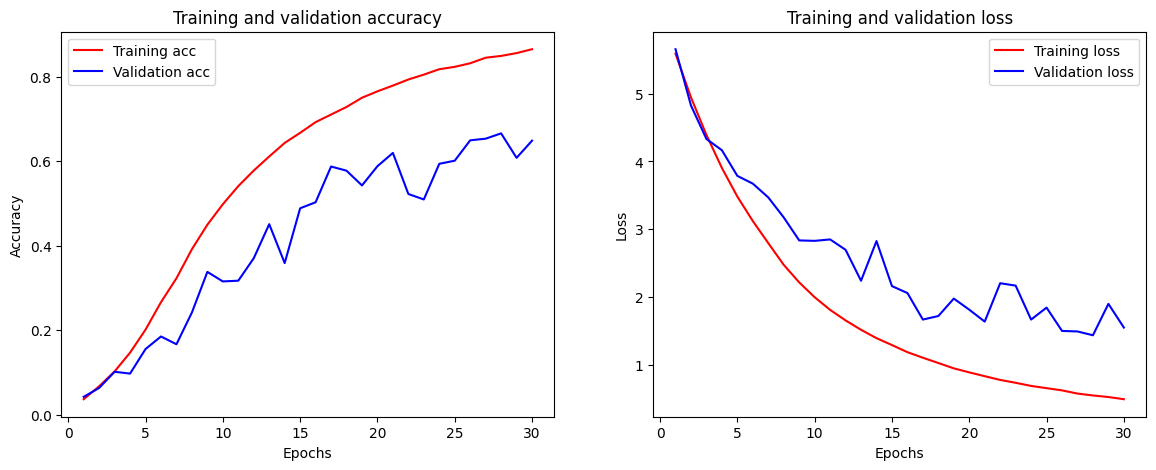

In [10]:
import matplotlib.pyplot as plt

# 假设 history.history 包含了训练集和验证集的准确率和损失值
# 使用 matplotlib 绘制训练和验证的准确率以及损失值

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 绘制训练和验证的准确率
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 绘制训练和验证的损失值
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## resnet50+se+dscnn+inception model

In [4]:
from tensorflow.keras import layers, models, regularizers
def squeeze_excite_block(input_tensor, reduction_ratio=16):
    # 获取通道数
    channels = input_tensor.shape[-1]
    se_shape = (1, 1, channels)

    # 全局平均池化
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)

    # 扩展路径1：更深的网络
    se_1 = layers.Dense(channels // reduction_ratio * 2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_1 = layers.Dense(channels // reduction_ratio, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se_1)
    se_1 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_1)

    # 扩展路径2：更宽的网络
    se_2 = layers.Dense(channels // reduction_ratio * 4, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_2 = layers.Dropout(0.5)(se_2)  # 添加 Dropout 防止过拟合
    se_2 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_2)

    # 融合两个路径
    se = layers.add([se_1, se_2])

    # 调整原始输入特征
    return layers.multiply([input_tensor, se])
def residual_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=True):
    # 瓶颈结构
    if conv_shortcut:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride, kernel_initializer='he_normal')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    # 第一层
    x = layers.Conv2D(filters, 1, strides=stride, kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 第二层
    x = layers.Conv2D(filters, kernel_size, padding='SAME', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 第三层
    x = layers.Conv2D(4 * filters, 1, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # 残差连接
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    
    return x
def depthwise_separable_conv_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=False, reduction_ratio=16):
    # 深度可分离卷积的深度卷积部分
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=stride, depth_multiplier=1, padding='same', kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 深度可分离卷积的逐点卷积部分
    x = layers.Conv2D(filters, 1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 如果需要，对shortcut进行处理
    if conv_shortcut or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_initializer='he_normal')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    # 应用SE块（如果有）
    x = squeeze_excite_block(x, reduction_ratio)

    # 合并主路径和shortcut
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x


def residual_inception_block(input_tensor, filters):
    # 分支1：1x1卷积
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)

    # 分支2：1x1卷积后接3x3卷积
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)

    # 分支3：1x1卷积后接5x5卷积
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)

    # 分支4：3x3最大池化后接1x1卷积
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)

    # 合并所有分支
    x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)

    # 残差连接
    shortcut = layers.Conv2D(4 * filters, (1, 1), strides=(1, 1), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x


In [5]:
from tensorflow.keras import layers, models, regularizers

def create_custom_resnet50(input_shape=(256, 256, 3), classes=1000):
    inputs = layers.Input(shape=input_shape)
    
    # 预处理
    x = layers.ZeroPadding2D(padding=(3, 3))(inputs)
    x = layers.Conv2D(64, 7, strides=2, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='SAME')(x)

    # 第一阶段，使用残差块
    x = residual_block(x, 64, stride=1, conv_shortcut=True)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # 第二阶段，使用深度可分离卷积
    x = depthwise_separable_conv_block(x, 128, stride=2)
    x = depthwise_separable_conv_block(x, 128)
    x = depthwise_separable_conv_block(x, 128)
    x = depthwise_separable_conv_block(x, 128)

    # 第三阶段，使用SE块增强的深度可分离卷积
    x = depthwise_separable_conv_block(x, 256, stride=2, conv_shortcut=True)
    x = depthwise_separable_conv_block(x, 256)
    x = depthwise_separable_conv_block(x, 256)
    x = depthwise_separable_conv_block(x, 256)
    x = depthwise_separable_conv_block(x, 256)
    x = depthwise_separable_conv_block(x, 256)

    # 第四阶段，使用残差Inception块
    x = residual_inception_block(x, 512)
    x = residual_inception_block(x, 512)
    x = residual_inception_block(x, 512)

    # 结尾部分
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(classes, activation='softmax')(x)
    
    # 创建模型
    model = models.Model(inputs, x, name='custom_resnet50')

    return model


In [6]:
from tensorflow.keras.utils import plot_model

# 假设你的自定义ResNet模型被命名为 create_custom_resnet50，并且输入尺寸为 (256, 256, 3)
input_shape = (256, 256, 3)
model = create_custom_resnet50(input_shape=input_shape, classes=len(train_generator.class_indices))


# 编译模型
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# 将模型结构保存为图像文件
plot_model(model, to_file='modelStructure.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=600, layer_range=None)


In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,  # 根据需要调整
)
model.save('resnet50demo.h5')

Epoch 1/30
843/843 [==============================] - 438s 516ms/step - loss: 2.7376 - accuracy: 0.2973 - val_loss: 2.6047 - val_accuracy: 0.3533
Epoch 2/30
843/843 [==============================] - 438s 520ms/step - loss: 1.5298 - accuracy: 0.5936 - val_loss: 1.3446 - val_accuracy: 0.6330
Epoch 3/30
843/843 [==============================] - 446s 529ms/step - loss: 1.1368 - accuracy: 0.6901 - val_loss: 1.2983 - val_accuracy: 0.6542
Epoch 4/30
843/843 [==============================] - 442s 524ms/step - loss: 0.9406 - accuracy: 0.7414 - val_loss: 1.1135 - val_accuracy: 0.6987
Epoch 5/30
843/843 [==============================] - 444s 527ms/step - loss: 0.7894 - accuracy: 0.7816 - val_loss: 1.2542 - val_accuracy: 0.6785
Epoch 6/30
843/843 [==============================] - 436s 517ms/step - loss: 0.7059 - accuracy: 0.8057 - val_loss: 1.0216 - val_accuracy: 0.7343
Epoch 7/30
843/843 [==============================] - 442s 525ms/step - loss: 0.6171 - accuracy: 0.8268 - val_loss: 1.1267 -

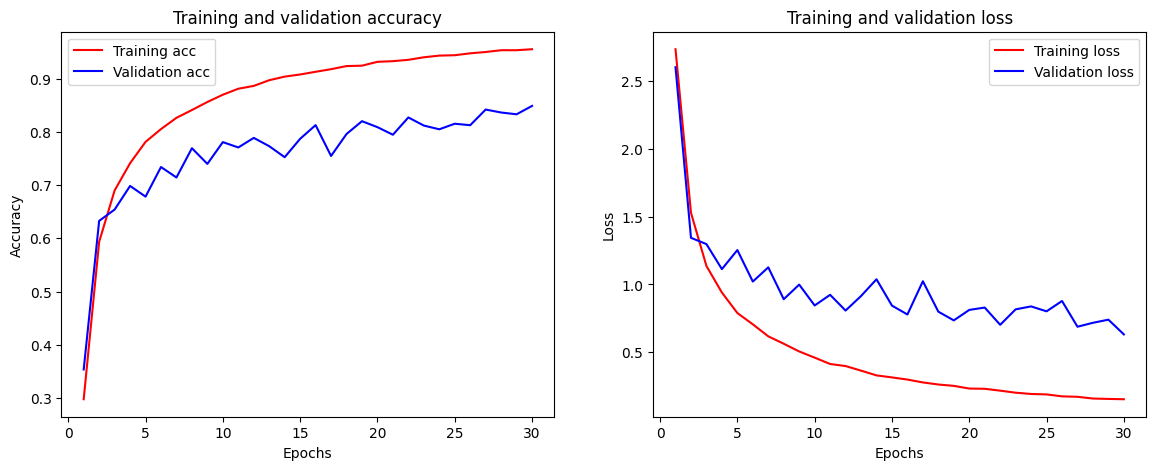

In [8]:
import matplotlib.pyplot as plt

# 假设 history.history 包含了训练集和验证集的准确率和损失值
# 使用 matplotlib 绘制训练和验证的准确率以及损失值

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 绘制训练和验证的准确率
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 绘制训练和验证的损失值
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Train model

## simple model

In [7]:
input_layer = Input(shape=(64, 64, 3))

# Convolutional layers with SE blocks
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = DepthwiseConv2D((3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)  # pointwise convolution
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  # SE block


x = Conv2D(64, (3, 3), activation='relu')(x)
x = DepthwiseConv2D((3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (1, 1), activation='relu', padding='same')(x)  # pointwise convolution
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  # SE block


x = Conv2D(128, (3, 3), activation='relu')(x)
x = DepthwiseConv2D((3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (1, 1), activation='relu', padding='same')(x)  # pointwise convolution
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  # SE block

x = Conv2D(256, (3, 3), activation='relu')(x)
x = DepthwiseConv2D((3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (1, 1), activation='relu', padding='same')(x)  # pointwise convolution
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  # SE block

# Flatten and Dense layers
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)   # Update the number of classes

# Create model
model = Model(inputs=input_layer, outputs=output_layer)


In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,  # You can change the number of epochs
    callbacks=[tensorboard_callback])  # Add the callback here


Epoch 1/50
374/374 [==============================] - 317s 832ms/step - loss: 2.9888 - accuracy: 0.0604 - val_loss: 2.9959 - val_accuracy: 0.0502
Epoch 2/50
374/374 [==============================] - 177s 473ms/step - loss: 2.9491 - accuracy: 0.0882 - val_loss: 2.9518 - val_accuracy: 0.0921
Epoch 3/50
374/374 [==============================] - 178s 475ms/step - loss: 2.9169 - accuracy: 0.0998 - val_loss: 2.8960 - val_accuracy: 0.1172
Epoch 4/50
374/374 [==============================] - 177s 473ms/step - loss: 2.8860 - accuracy: 0.1128 - val_loss: 2.8585 - val_accuracy: 0.1266
Epoch 5/50
374/374 [==============================] - 177s 473ms/step - loss: 2.8634 - accuracy: 0.1197 - val_loss: 2.8461 - val_accuracy: 0.1232
Epoch 6/50
374/374 [==============================] - 177s 472ms/step - loss: 2.8364 - accuracy: 0.1335 - val_loss: 2.8013 - val_accuracy: 0.1486
Epoch 7/50
374/374 [==============================] - 177s 473ms/step - loss: 2.8035 - accuracy: 0.1447 - val_loss: 2.7873 -

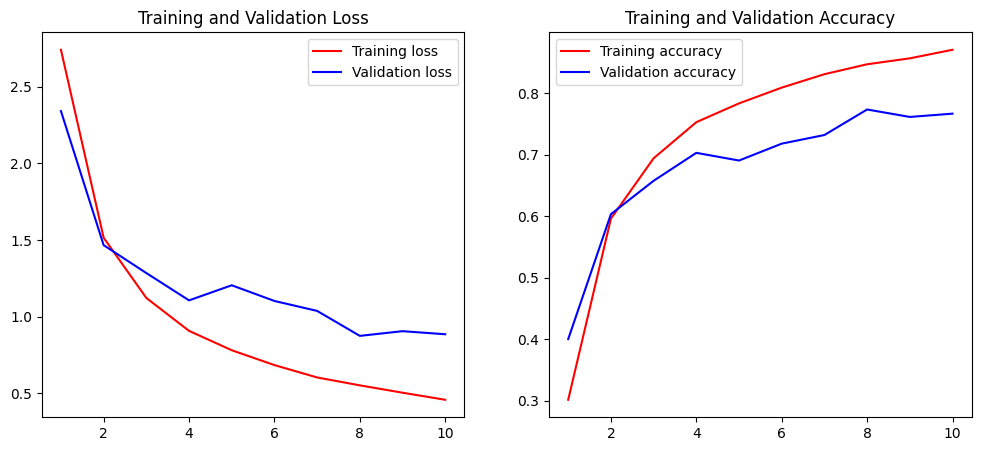

In [16]:
# 保存 history 对象的数据以便之后分析
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# 可选：绘制训练和验证损失/准确度
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [12]:
%load_ext tensorboard

%tensorboard --logdir logs/fit


## resnet50

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))

In [12]:
num_classes = len(train_generator.class_indices)

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 查看模型结构
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [14]:
# 训练新模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[tensorboard_callback]
)

Epoch 1/10


843/843 [==============================] - 3382s 4s/step - loss: 2.7426 - accuracy: 0.3012 - val_loss: 2.3426 - val_accuracy: 0.4000
Epoch 2/10
843/843 [==============================] - 3367s 4s/step - loss: 1.5155 - accuracy: 0.5960 - val_loss: 1.4668 - val_accuracy: 0.6033
Epoch 3/10
843/843 [==============================] - 3270s 4s/step - loss: 1.1219 - accuracy: 0.6943 - val_loss: 1.2845 - val_accuracy: 0.6576
Epoch 4/10
843/843 [==============================] - 3249s 4s/step - loss: 0.9071 - accuracy: 0.7530 - val_loss: 1.1062 - val_accuracy: 0.7031
Epoch 5/10
843/843 [==============================] - 3242s 4s/step - loss: 0.7805 - accuracy: 0.7836 - val_loss: 1.2047 - val_accuracy: 0.6906
Epoch 6/10
843/843 [==============================] - 3213s 4s/step - loss: 0.6835 - accuracy: 0.8093 - val_loss: 1.1023 - val_accuracy: 0.7181
Epoch 7/10
843/843 [==============================] - 3199s 4s/step - loss: 0.6027 - accuracy: 0.8311 - val_loss: 1.0373 - val_accurac

In [15]:
model.save('demo.h5') 

C:\Users\m1355\anaconda3\envs\CRC\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## resnet50+se+dscnn+inception summary

In [2]:
from tensorflow.keras import layers, models, regularizers
def squeeze_excite_block(input_tensor, reduction_ratio=16):
    # 获取通道数
    channels = input_tensor.shape[-1]
    se_shape = (1, 1, channels)

    # 全局平均池化
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)

    # 扩展路径1：更深的网络
    se_1 = layers.Dense(channels // reduction_ratio * 2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_1 = layers.Dense(channels // reduction_ratio, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se_1)
    se_1 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_1)

    # 扩展路径2：更宽的网络
    se_2 = layers.Dense(channels // reduction_ratio * 4, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se_2 = layers.Dropout(0.5)(se_2)  # 添加 Dropout 防止过拟合
    se_2 = layers.Dense(channels, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se_2)

    # 融合两个路径
    se = layers.add([se_1, se_2])

    # 调整原始输入特征
    return layers.multiply([input_tensor, se])
def residual_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=True):
    # 瓶颈结构
    if conv_shortcut:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride, kernel_initializer='he_normal')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    # 第一层
    x = layers.Conv2D(filters, 1, strides=stride, kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 第二层
    x = layers.Conv2D(filters, kernel_size, padding='SAME', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 第三层
    x = layers.Conv2D(4 * filters, 1, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # 残差连接
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    
    return x
def depthwise_separable_conv_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=False, reduction_ratio=16):
    # 深度可分离卷积的深度卷积部分
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=stride, depth_multiplier=1, padding='same', kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 深度可分离卷积的逐点卷积部分
    x = layers.Conv2D(filters, 1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 如果需要，对shortcut进行处理
    if conv_shortcut or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_initializer='he_normal')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    # 应用SE块（如果有）
    x = squeeze_excite_block(x, reduction_ratio)

    # 合并主路径和shortcut
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x


def residual_inception_block(input_tensor, filters):
    # 分支1：1x1卷积
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)

    # 分支2：1x1卷积后接3x3卷积
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)

    # 分支3：1x1卷积后接5x5卷积
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)

    # 分支4：3x3最大池化后接1x1卷积
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)

    # 合并所有分支
    x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)

    # 残差连接
    shortcut = layers.Conv2D(4 * filters, (1, 1), strides=(1, 1), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x


In [3]:
from tensorflow.keras import layers, models, regularizers

def create_custom_resnet50(input_shape=(256, 256, 3), classes=1000):
    inputs = layers.Input(shape=input_shape)
    
    # 预处理
    x = layers.ZeroPadding2D(padding=(3, 3))(inputs)
    x = layers.Conv2D(64, 7, strides=2, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='SAME')(x)

    # 第一阶段，使用残差块
    x = residual_block(x, 64, stride=1, conv_shortcut=True)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # 第二阶段，使用深度可分离卷积
    x = depthwise_separable_conv_block(x, 128, stride=2)
    x = depthwise_separable_conv_block(x, 128)
    x = depthwise_separable_conv_block(x, 128)
    x = depthwise_separable_conv_block(x, 128)

    # 第三阶段，使用SE块增强的深度可分离卷积
    x = depthwise_separable_conv_block(x, 256, stride=2, conv_shortcut=True)
    x = depthwise_separable_conv_block(x, 256)
    x = depthwise_separable_conv_block(x, 256)
    x = depthwise_separable_conv_block(x, 256)
    x = depthwise_separable_conv_block(x, 256)
    x = depthwise_separable_conv_block(x, 256)

    # 第四阶段，使用残差Inception块
    x = residual_inception_block(x, 512)
    x = residual_inception_block(x, 512)
    x = residual_inception_block(x, 512)

    # 结尾部分
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(classes, activation='softmax')(x)
    
    # 创建模型
    model = models.Model(inputs, x, name='custom_resnet50')

    return model


In [4]:
# Create the model
model =  create_custom_resnet50()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# 查看模型结构
model.summary()

Model: "custom_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                    

## resnet50+se+dscnn+inception train

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('resnetdemo.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
]

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # 根据需要调整
    callbacks=callbacks
)

Epoch 1/10


2024-03-20 11:27:44.558599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-20 11:27:48.913411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-20 11:27:49.971851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-20 11:27:50.405027: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1be113c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-20 11:27:50.405113: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-20 11:27:50.414508: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_ut

843/843 [==============================] - ETA: 0s - loss: 4.0077 - accuracy: 0.0494

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


843/843 [==============================] - 900s 1s/step - loss: 4.0077 - accuracy: 0.0494 - val_loss: 3.9417 - val_accuracy: 0.0528 - lr: 1.0000e-04
Epoch 2/10
843/843 [==============================] - 825s 978ms/step - loss: 3.7055 - accuracy: 0.0883 - val_loss: 3.9050 - val_accuracy: 0.0559 - lr: 1.0000e-04
Epoch 3/10
843/843 [==============================] - 819s 971ms/step - loss: 3.5145 - accuracy: 0.1242 - val_loss: 3.6825 - val_accuracy: 0.0892 - lr: 1.0000e-04
Epoch 4/10
843/843 [==============================] - 829s 984ms/step - loss: 3.3139 - accuracy: 0.1686 - val_loss: 3.5926 - val_accuracy: 0.1235 - lr: 1.0000e-04
Epoch 5/10
843/843 [==============================] - 827s 981ms/step - loss: 3.0756 - accuracy: 0.2225 - val_loss: 3.3098 - val_accuracy: 0.1760 - lr: 1.0000e-04
Epoch 6/10
463/843 [===============>..............] - ETA: 3:39 - loss: 2.8932 - accuracy: 0.2622

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



843/843 [==============================] - 894s 1s/step - loss: 2.6187 - accuracy: 0.3277 - val_loss: 2.9443 - val_accuracy: 0.2609 - lr: 1.0000e-04
Epoch 8/10
843/843 [==============================] - 848s 1s/step - loss: 2.4202 - accuracy: 0.3763 - val_loss: 3.3350 - val_accuracy: 0.2422 - lr: 1.0000e-04
Epoch 9/10
843/843 [==============================] - 853s 1s/step - loss: 2.2332 - accuracy: 0.4212 - val_loss: 2.5855 - val_accuracy: 0.3468 - lr: 1.0000e-04
Epoch 10/10
843/843 [==============================] - 844s 1s/step - loss: 2.0614 - accuracy: 0.4618 - val_loss: 2.7300 - val_accuracy: 0.3276 - lr: 1.0000e-04


In [15]:
from tensorflow.keras.models import load_model
model = load_model('resnetdemo.h5')
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('resnetdemo2.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
]

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # 根据需要调整
    callbacks=callbacks
)

Epoch 1/10


2024-03-20 13:50:38.067368: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 890s 1s/step - loss: 2.0472 - accuracy: 0.4618 - val_loss: 2.7207 - val_accuracy: 0.3226 - lr: 1.0000e-04
Epoch 2/10
843/843 [==============================] - 833s 988ms/step - loss: 1.8925 - accuracy: 0.5044 - val_loss: 2.4308 - val_accuracy: 0.4106 - lr: 1.0000e-04
Epoch 3/10
843/843 [==============================] - 833s 989ms/step - loss: 1.7622 - accuracy: 0.5330 - val_loss: 2.2204 - val_accuracy: 0.4387 - lr: 1.0000e-04
Epoch 4/10
843/843 [==============================] - 841s 998ms/step - loss: 1.6315 - accuracy: 0.5642 - val_loss: 2.0096 - val_accuracy: 0.4895 - lr: 1.0000e-04
Epoch 5/10
843/843 [==============================] - 849s 1s/step - loss: 1.5133 - accuracy: 0.5939 - val_loss: 1.9988 - val_accuracy: 0.4971 - lr: 1.0000e-04
Epoch 6/10
843/843 [==============================] - 852s 1s/step - loss: 1.3999 - accuracy: 0.6228 - val_loss: 2.2198 - val_accuracy: 0.4563 - lr: 1.0000e-04
Epoch 7/10
843/843 [======================

In [16]:
from tensorflow.keras.models import load_model
model = load_model('resnetdemo2.h5')
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('resnetdemo3.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
]

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # 根据需要调整
    callbacks=callbacks
)

Epoch 1/10


2024-03-20 16:13:29.997983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 891s 1s/step - loss: 1.1956 - accuracy: 0.6727 - val_loss: 2.1399 - val_accuracy: 0.4869 - lr: 1.0000e-04
Epoch 2/10
843/843 [==============================] - 847s 1s/step - loss: 1.1069 - accuracy: 0.7002 - val_loss: 1.9467 - val_accuracy: 0.5174 - lr: 1.0000e-04
Epoch 3/10
843/843 [==============================] - 846s 1s/step - loss: 1.0214 - accuracy: 0.7205 - val_loss: 1.8487 - val_accuracy: 0.5509 - lr: 1.0000e-04
Epoch 4/10
843/843 [==============================] - 847s 1s/step - loss: 0.9400 - accuracy: 0.7412 - val_loss: 1.8577 - val_accuracy: 0.5419 - lr: 1.0000e-04
Epoch 5/10
843/843 [==============================] - 835s 991ms/step - loss: 0.8718 - accuracy: 0.7599 - val_loss: 1.8562 - val_accuracy: 0.5541 - lr: 1.0000e-04
Epoch 6/10
843/843 [==============================] - 849s 1s/step - loss: 0.8020 - accuracy: 0.7748 - val_loss: 1.7728 - val_accuracy: 0.5751 - lr: 1.0000e-04
Epoch 7/10
843/843 [============================

In [17]:
from tensorflow.keras.models import load_model
model = load_model('resnetdemo3.h5')
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('resnetdemo4.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
]

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # 根据需要调整
    callbacks=callbacks
)

model.save('resnetdemo41.h5')  # 保存模型到HDF5文件


Epoch 1/10


2024-03-20 18:36:57.235497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 867s 978ms/step - loss: 0.5990 - accuracy: 0.8320 - val_loss: 1.8039 - val_accuracy: 0.5861 - lr: 1.0000e-04
Epoch 2/10
843/843 [==============================] - 817s 970ms/step - loss: 0.5285 - accuracy: 0.8535 - val_loss: 1.6316 - val_accuracy: 0.6286 - lr: 1.0000e-04
Epoch 3/10
843/843 [==============================] - 813s 964ms/step - loss: 0.5008 - accuracy: 0.8588 - val_loss: 1.7550 - val_accuracy: 0.6317 - lr: 1.0000e-04
Epoch 4/10
843/843 [==============================] - 857s 1s/step - loss: 0.4561 - accuracy: 0.8695 - val_loss: 1.7668 - val_accuracy: 0.6234 - lr: 1.0000e-04
Epoch 5/10
843/843 [==============================] - 789s 936ms/step - loss: 0.4249 - accuracy: 0.8789 - val_loss: 1.7388 - val_accuracy: 0.6187 - lr: 1.0000e-04
Epoch 6/10
843/843 [==============================] - 787s 934ms/step - loss: 0.4041 - accuracy: 0.8851 - val_loss: 1.7565 - val_accuracy: 0.6406 - lr: 1.0000e-04
Epoch 7/10
843/843 [================

In [18]:
from tensorflow.keras.models import load_model
model = load_model('resnetdemo4.h5')
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('resnetdemo5.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
]

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # 根据需要调整
    callbacks=callbacks
)

model.save('resnetdemo51.h5')  # 保存模型到HDF5文件


Epoch 1/10


2024-03-20 20:56:18.149936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 823s 928ms/step - loss: 0.3387 - accuracy: 0.9031 - val_loss: 1.9556 - val_accuracy: 0.6323 - lr: 1.0000e-04
Epoch 2/10
843/843 [==============================] - 786s 933ms/step - loss: 0.3111 - accuracy: 0.9104 - val_loss: 1.7538 - val_accuracy: 0.6452 - lr: 1.0000e-04
Epoch 3/10
843/843 [==============================] - 780s 926ms/step - loss: 0.2941 - accuracy: 0.9163 - val_loss: 1.8266 - val_accuracy: 0.6312 - lr: 1.0000e-04
Epoch 4/10
843/843 [==============================] - 789s 936ms/step - loss: 0.2800 - accuracy: 0.9213 - val_loss: 1.7924 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 5/10
843/843 [==============================] - 783s 929ms/step - loss: 0.2639 - accuracy: 0.9251 - val_loss: 1.6993 - val_accuracy: 0.6480 - lr: 1.0000e-04
Epoch 6/10
843/843 [==============================] - 797s 946ms/step - loss: 0.2506 - accuracy: 0.9273 - val_loss: 1.8361 - val_accuracy: 0.6417 - lr: 1.0000e-04
Epoch 7/10
843/843 [=============

In [19]:
from tensorflow.keras.models import load_model
model = load_model('resnetdemo5.h5')
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('resnetdemo6.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
]

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # 根据需要调整
    callbacks=callbacks
)

model.save('resnetdemo61.h5')  # 保存模型到HDF5文件


Epoch 1/10


2024-03-20 23:12:25.445528: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 839s 947ms/step - loss: 0.2572 - accuracy: 0.9267 - val_loss: 1.9007 - val_accuracy: 0.6510 - lr: 1.0000e-04
Epoch 2/10
843/843 [==============================] - 792s 939ms/step - loss: 0.2422 - accuracy: 0.9312 - val_loss: 1.8101 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 3/10
843/843 [==============================] - 781s 927ms/step - loss: 0.2242 - accuracy: 0.9363 - val_loss: 1.8222 - val_accuracy: 0.6448 - lr: 1.0000e-04
Epoch 4/10
843/843 [==============================] - 781s 927ms/step - loss: 0.2045 - accuracy: 0.9430 - val_loss: 1.9801 - val_accuracy: 0.6320 - lr: 1.0000e-04
Epoch 5/10
843/843 [==============================] - 772s 916ms/step - loss: 0.2058 - accuracy: 0.9420 - val_loss: 2.0779 - val_accuracy: 0.6296 - lr: 1.0000e-04
Epoch 6/10
843/843 [==============================] - 778s 923ms/step - loss: 0.1926 - accuracy: 0.9455 - val_loss: 1.9239 - val_accuracy: 0.6680 - lr: 1.0000e-04
Epoch 7/10
843/843 [=============

In [20]:
from tensorflow.keras.models import load_model
model = load_model('resnetdemo6.h5')
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('resnetdemo7.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
]

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # 根据需要调整
    callbacks=callbacks
)

model.save('resnetdemo71.h5')  # 保存模型到HDF5文件


Epoch 1/10


2024-03-21 05:36:44.649068: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 836s 954ms/step - loss: 2.6174 - accuracy: 0.3604 - val_loss: 4.0260 - val_accuracy: 0.2168 - lr: 0.0010
Epoch 2/10
843/843 [==============================] - 798s 946ms/step - loss: 1.7501 - accuracy: 0.5330 - val_loss: 3.3418 - val_accuracy: 0.3329 - lr: 0.0010
Epoch 3/10
843/843 [==============================] - 772s 916ms/step - loss: 1.4382 - accuracy: 0.6130 - val_loss: 2.5967 - val_accuracy: 0.4133 - lr: 0.0010
Epoch 4/10
843/843 [==============================] - 769s 912ms/step - loss: 1.2561 - accuracy: 0.6605 - val_loss: 2.8767 - val_accuracy: 0.3818 - lr: 0.0010
Epoch 5/10
843/843 [==============================] - 766s 908ms/step - loss: 1.1064 - accuracy: 0.7019 - val_loss: 1.8861 - val_accuracy: 0.5696 - lr: 0.0010
Epoch 6/10
843/843 [==============================] - 768s 912ms/step - loss: 0.8779 - accuracy: 0.7626 - val_loss: 2.2763 - val_accuracy: 0.5233 - lr: 0.0010
Epoch 8/10
843/843 [==============================] - 812

In [21]:
from tensorflow.keras.models import load_model
model = load_model('resnetdemo7.h5')
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('resnetdemo8.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
]

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # 根据需要调整
    callbacks=callbacks
)

model.save('resnetdemo81.h5')  # 保存模型到HDF5文件


Epoch 1/10


2024-03-21 08:06:08.397006: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 802s 915ms/step - loss: 0.6798 - accuracy: 0.8105 - val_loss: 1.3747 - val_accuracy: 0.6782 - lr: 0.0010
Epoch 2/10
843/843 [==============================] - 812s 963ms/step - loss: 0.6403 - accuracy: 0.8235 - val_loss: 1.3822 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 3/10
843/843 [==============================] - 823s 976ms/step - loss: 0.5853 - accuracy: 0.8394 - val_loss: 1.3851 - val_accuracy: 0.6561 - lr: 0.0010
Epoch 4/10
843/843 [==============================] - 791s 939ms/step - loss: 0.5451 - accuracy: 0.8487 - val_loss: 1.8112 - val_accuracy: 0.5512 - lr: 0.0010
Epoch 5/10
843/843 [==============================] - 788s 935ms/step - loss: 0.5468 - accuracy: 0.8497 - val_loss: 1.6308 - val_accuracy: 0.6072 - lr: 0.0010
Epoch 6/10
843/843 [==============================] - 793s 941ms/step - loss: 0.4987 - accuracy: 0.8641 - val_loss: 1.3082 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 7/10
843/843 [==============================] - 809

In [22]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import numpy as np

model = load_model('resnetdemo8.h5')

# 定义学习率调整函数
def scheduler(epoch, lr):
    if epoch < 5:
        return 1e-5  # 预热阶段的学习率
    else:
        return 1e-4 * np.exp(0.1 * (5 - epoch))  # 随着epoch增大，学习率逐渐减小

# 添加LearningRateScheduler到回调
callbacks = [
    ModelCheckpoint('resnetdemo9.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6),
    LearningRateScheduler(scheduler, verbose=1)
]

model.compile(optimizer=Adam(learning_rate=1e-5),  # 使用更低的初始学习率
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15,
    callbacks=callbacks
)

model.save('resnetdemo9final.h5')



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/15


2024-03-21 10:35:37.644119: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 861s 973ms/step - loss: 0.2893 - accuracy: 0.9173 - val_loss: 0.9695 - val_accuracy: 0.7893 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/15
843/843 [==============================] - 821s 974ms/step - loss: 0.2132 - accuracy: 0.9407 - val_loss: 0.9420 - val_accuracy: 0.7960 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-05.
Epoch 3/15
843/843 [==============================] - 825s 979ms/step - loss: 0.1884 - accuracy: 0.9470 - val_loss: 0.9425 - val_accuracy: 0.8024 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1e-05.
Epoch 4/15
843/843 [==============================] - 833s 988ms/step - loss: 0.1715 - accuracy: 0.9529 - val_loss: 0.9386 - val_accuracy: 0.8047 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/15
843/843 [==============================] - 879s 1s/step - loss: 0.1554 - accuracy: 0.9566 - 

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import numpy as np
import tensorflow.keras.backend as K





2024-03-23 11:09:18.000476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 11:09:18.122379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 11:09:18.122846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import numpy as np
model = load_model('resnetdemo9final.h5')
# 定义学习率调整函数
def scheduler(epoch, lr):
    if epoch < 5:
        return 1e-5  # 预热阶段的学习率
    else:
        return 1e-4 * np.exp(0.1 * (5 - epoch))  # 随着epoch增大，学习率逐渐减小

# 添加LearningRateScheduler到回调
callbacks = [
    ModelCheckpoint('resnetdemo10.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6),
    LearningRateScheduler(scheduler, verbose=1)
]

model.compile(optimizer=Adam(learning_rate=1e-5),  # 使用更低的初始学习率
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15,
    callbacks=callbacks
)

model.save('resnetdemo10final.h5')


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/15


2024-03-23 11:29:44.417297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-23 11:29:49.417168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-23 11:29:50.558742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-23 11:29:50.985795: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa0275e3410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-23 11:29:50.985842: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-23 11:29:50.991566: I tensorflow/compiler/mlir/tensorflow/utils/dump_mli

843/843 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9854

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


843/843 [==============================] - 991s 1s/step - loss: 0.0579 - accuracy: 0.9854 - val_loss: 0.9753 - val_accuracy: 0.8265 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/15
843/843 [==============================] - 937s 1s/step - loss: 0.0570 - accuracy: 0.9863 - val_loss: 0.9774 - val_accuracy: 0.8248 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-05.
Epoch 3/15
843/843 [==============================] - 933s 1s/step - loss: 0.0565 - accuracy: 0.9861 - val_loss: 0.9759 - val_accuracy: 0.8273 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1e-05.
Epoch 4/15
843/843 [==============================] - 914s 1s/step - loss: 0.0552 - accuracy: 0.9861 - val_loss: 0.9986 - val_accuracy: 0.8235 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/15
843/843 [==============================] - 936s 1s/step - loss: 0.0535 - accuracy: 0.9871 - val_loss: 0.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import numpy as np
model = load_model('resnetdemo10final.h5')
# 定义学习率调整函数
def scheduler(epoch, lr):
    if epoch < 5:
        return 1e-5  # 预热阶段的学习率
    else:
        return 1e-4 * np.exp(0.1 * (5 - epoch))  # 随着epoch增大，学习率逐渐减小

# 添加LearningRateScheduler到回调
callbacks = [
    ModelCheckpoint('resnetdemo11.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6),
    LearningRateScheduler(scheduler, verbose=1)
]

model.compile(optimizer=Adam(learning_rate=1e-5),  # 使用更低的初始学习率
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15,
 


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/15


2024-03-23 14:28:03.523031: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 962s 1s/step - loss: 0.0364 - accuracy: 0.9917 - val_loss: 1.0087 - val_accuracy: 0.8275 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1e-05.
Epoch 4/15
843/843 [==============================] - 944s 1s/step - loss: 0.0386 - accuracy: 0.9911 - val_loss: 1.0205 - val_accuracy: 0.8272 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/15
843/843 [==============================] - 955s 1s/step - loss: 0.0388 - accuracy: 0.9910 - val_loss: 1.0132 - val_accuracy: 0.8302 - lr: 1.0000e-05

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/15
776/843 [==========================>...] - ETA: 44s - loss: 0.0605 - accuracy: 0.9838

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



843/843 [==============================] - 954s 1s/step - loss: 0.0618 - accuracy: 0.9833 - val_loss: 1.0598 - val_accuracy: 0.8117 - lr: 1.0000e-04

Epoch 7: LearningRateScheduler setting learning rate to 9.048374180359596e-05.
Epoch 7/15
358/843 [===========>..................] - ETA: 5:36 - loss: 0.0469 - accuracy: 0.9878

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model = load_model('resnetdemo11.h5')

# 更新回调，移除LearningRateScheduler
callbacks = [
    ModelCheckpoint('resnetdemo12.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
]

# 编译模型时设置学习率为1e-5
model.compile(optimizer=Adam(learning_rate=1e-5),  # 保持学习率为1e-5
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15,
    callbacks=callbacks
)

model.save('resnetdemo12final.h5')


2024-03-23 19:14:53.730447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 19:14:53.741429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 19:14:53.741711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/15


2024-03-23 19:15:17.814764: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-23 19:15:23.269464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-23 19:15:24.502354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-23 19:15:24.939234: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6e92fd1a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-23 19:15:24.939303: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-23 19:15:24.946980: I tensorflow/compiler/mlir/tensorflow/utils/dump_mli

843/843 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9906

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


843/843 [==============================] - 999s 1s/step - loss: 0.0383 - accuracy: 0.9906 - val_loss: 1.0131 - val_accuracy: 0.8265 - lr: 1.0000e-05
Epoch 2/15
843/843 [==============================] - 949s 1s/step - loss: 0.0416 - accuracy: 0.9900 - val_loss: 1.0174 - val_accuracy: 0.8265 - lr: 1.0000e-05
Epoch 3/15
843/843 [==============================] - 958s 1s/step - loss: 0.0356 - accuracy: 0.9918 - val_loss: 1.0287 - val_accuracy: 0.8306 - lr: 1.0000e-05
Epoch 4/15
843/843 [==============================] - 958s 1s/step - loss: 0.0361 - accuracy: 0.9913 - val_loss: 1.0067 - val_accuracy: 0.8297 - lr: 1.0000e-05
Epoch 5/15
843/843 [==============================] - 1011s 1s/step - loss: 0.0341 - accuracy: 0.9925 - val_loss: 1.0146 - val_accuracy: 0.8298 - lr: 2.0000e-06
Epoch 12/15
843/843 [==============================] - 1019s 1s/step - loss: 0.0342 - accuracy: 0.9923 - val_loss: 1.0127 - val_accuracy: 0.8315 - lr: 2.0000e-06
Epoch 13/15
843/843 [===========================

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model = load_model('resnetdemo12final.h5')

# 更新回调，移除LearningRateScheduler
callbacks = [
    ModelCheckpoint('resnetdemo13.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
]

# 编译模型时设置学习率为1e-5
model.compile(optimizer=Adam(learning_rate=1e-5),  # 保持学习率为1e-5
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15,
    callbacks=callbacks
)

model.save('resnetdemo13final.h5')


Epoch 1/15


2024-03-23 23:34:54.817121: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_resnet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 1090s 1s/step - loss: 0.0313 - accuracy: 0.9931 - val_loss: 1.0450 - val_accuracy: 0.8318 - lr: 1.0000e-05
Epoch 2/15
843/843 [==============================] - 1026s 1s/step - loss: 0.0338 - accuracy: 0.9924 - val_loss: 1.0256 - val_accuracy: 0.8307 - lr: 1.0000e-05
Epoch 3/15
843/843 [==============================] - 1047s 1s/step - loss: 0.0340 - accuracy: 0.9929 - val_loss: 1.0148 - val_accuracy: 0.8310 - lr: 1.0000e-05
Epoch 4/15
843/843 [==============================] - 1003s 1s/step - loss: 0.0295 - accuracy: 0.9941 - val_loss: 1.0449 - val_accuracy: 0.8292 - lr: 1.0000e-05
Epoch 5/15
843/843 [==============================] - 899s 1s/step - loss: 0.0327 - accuracy: 0.9926 - val_loss: 1.0311 - val_accuracy: 0.8321 - lr: 1.0000e-05
Epoch 6/15
843/843 [==============================] - 907s 1s/step - loss: 0.0320 - accuracy: 0.9928 - val_loss: 1.0368 - val_accuracy: 0.8315 - lr: 1.0000e-05
Epoch 7/15
843/843 [===========================

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# 加载模型，跳过编译步骤
model = load_model('resnetdemo13.h5', compile=False)

# 现在手动编译模型，使用标准优化器和适当的参数
model.compile(optimizer=Adam(learning_rate=1e-5),  # 请根据需要选择合适的优化器和参数
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# 更新回调，移除LearningRateScheduler
callbacks = [
    ModelCheckpoint('resnetdemo14.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
]

# 编译模型时设置学习率为1e-5
model.compile(optimizer=Adam(learning_rate=1e-5),  # 保持学习率为1e-5
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15,
    callbacks=callbacks
)

model.save('resnetdemo14final.h5')


Epoch 1/15
843/843 [==============================] - 577s 665ms/step - loss: 0.0303 - accuracy: 0.9933 - val_loss: 1.0456 - val_accuracy: 0.8293 - lr: 1.0000e-05
Epoch 2/15
843/843 [==============================] - 454s 539ms/step - loss: 0.0299 - accuracy: 0.9932 - val_loss: 1.0393 - val_accuracy: 0.8316 - lr: 1.0000e-05
Epoch 3/15
843/843 [==============================] - 436s 518ms/step - loss: 0.0310 - accuracy: 0.9932 - val_loss: 1.0434 - val_accuracy: 0.8313 - lr: 1.0000e-05
Epoch 4/15
843/843 [==============================] - 443s 525ms/step - loss: 0.0290 - accuracy: 0.9939 - val_loss: 1.0448 - val_accuracy: 0.8308 - lr: 1.0000e-05
Epoch 5/15
843/843 [==============================] - 436s 518ms/step - loss: 0.0301 - accuracy: 0.9934 - val_loss: 1.0266 - val_accuracy: 0.8308 - lr: 1.0000e-05
Epoch 6/15
843/843 [==============================] - 444s 527ms/step - loss: 0.0289 - accuracy: 0.9937 - val_loss: 1.0285 - val_accuracy: 0.8329 - lr: 1.0000e-05
Epoch 7/15
843/843 [==

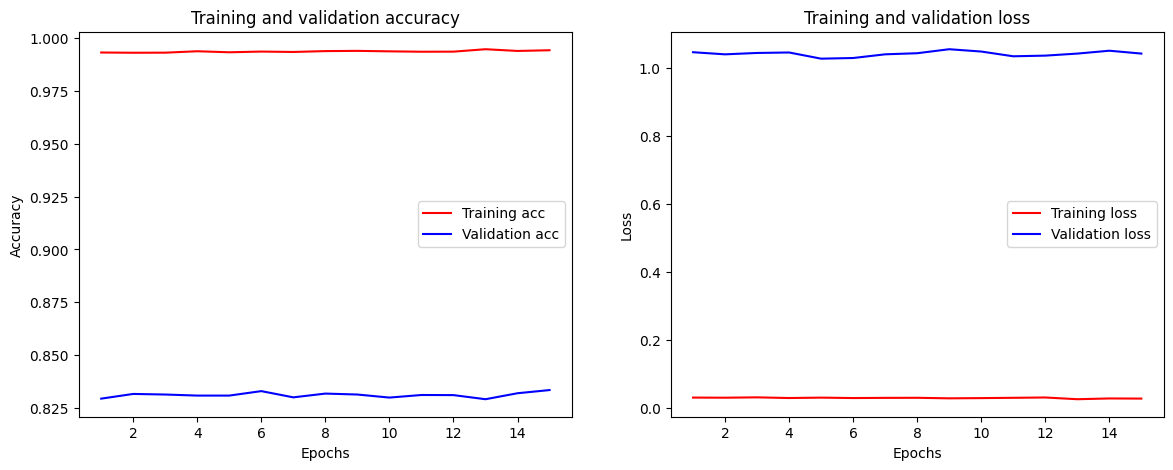

In [13]:
import matplotlib.pyplot as plt

# 假设 history.history 包含了训练集和验证集的准确率和损失值
# 使用 matplotlib 绘制训练和验证的准确率以及损失值

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 绘制训练和验证的准确率
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 绘制训练和验证的损失值
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Using best model prediction

In [4]:
model_path = 'resnetdemo13.h5'

In [5]:
from tensorflow.keras.preprocessing import image
# Load the trained model
model = tf.keras.models.load_model(model_path,compile=False)
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
def predict_vehicle_logo(image_path, model):
    # 图像预处理
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 为批量维度添加轴
    img_array /= 255.0  # 归一化到0-1之间

    # 使用模型进行预测
    predictions = model.predict(img_array)

    # 获取最高概率的标签索引
    predicted_index = np.argmax(predictions, axis=1)[0]

    # 将索引映射回标签
    labels = {v: k for k, v in train_generator.class_indices.items()}  # 反转标签字典
    predicted_label = labels[predicted_index]

    return predicted_label



In [6]:
image_path = r'E:\Download\aaa\aaa\GMC\000469.jpg'
# Run the prediction function
result = predict_vehicle_logo(image_path, model)
print(f"The image at {image_path} is predicted to be a {result}.")

1/1 [==============================] - 2s 2s/step
The image at E:\Download\aaa\aaa\GMC\000469.jpg is predicted to be a GMC.


In [7]:
image_path1 = r'E:\Download\aaa\aaa\JEEP\025459.jpg'
# Run the prediction function
result = predict_vehicle_logo(image_path1, model)
print(f"The image at {image_path} is predicted to be a {result}.")

1/1 [==============================] - 0s 19ms/step
The image at E:\Download\aaa\aaa\GMC\000469.jpg is predicted to be a JEEP.


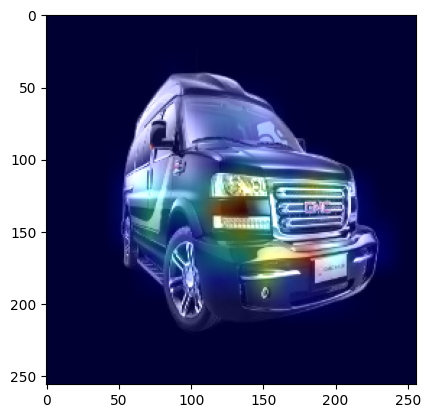

In [8]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Resize the heatmap to match the size of the image
    jet = cv2.resize(jet, (img.shape[1], img.shape[0]))

    # Create an image with RGB colorized heatmap
    superimposed_img = jet * alpha + img

    # Ensure the superimposed image is of type float32, then convert to [0,255] integer type
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Convert color from BGR to RGB
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Display Image
    plt.imshow(superimposed_img)
    plt.show()



# Use the function with an example
last_conv_layer_name = "conv2d_45"  # You should set the name of the last convolutional layer of your model
img_array = img_to_array(load_img(image_path, target_size=(256, 256)))  # Load your image
img_array = np.expand_dims(img_array, axis=0)  # Make it a batch
img_array /= 255.0  # Normalize

# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display the heatmap
display_gradcam(image_path, heatmap)


In [9]:
import os

def get_labels_from_directory(directory_path):
    # 获取指定目录下的所有项
    all_items = os.listdir(directory_path)
    
    # 过滤出所有的子目录，假设每个子目录的名称就是一个标签
    labels = [item for item in all_items if os.path.isdir(os.path.join(directory_path, item))]
    
    return labels

directory_path = r'E:\Download\aaa\aaa'
labels = get_labels_from_directory(directory_path)
print("Found labels:", labels)


Found labels: ['AUDI', 'BAOJUN', 'Benz', 'BMW', 'Buick', 'BYD', 'Cadillac', 'Changan', 'CHERY', 'Chevrolet', 'Citroen', 'Coupe', 'FAWHaima', 'Ford', 'Geely', 'GMC', 'HAVAL', 'HONDA', 'Hyundai', 'INFINITI', 'JEEP', 'KIA', 'Lexus', 'Lincoln', 'Mazda', 'MG', 'Mitsubishi', 'Nissan', 'PEUGEOT', 'Porsche', 'Qoros', 'RANGEROVER', 'Renault', 'ROEWE', 'Saab', 'SKODA', 'SoueastMotor', 'Subaru', 'SUZUKI', 'TOYOTA', 'TRUMCHI', 'Venucia', 'Volkswagen', 'VOLVO', 'WuLing']


In [10]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

model_path = 'resnetdemo13.h5'
model = tf.keras.models.load_model(model_path,compile=False)
model.compile(optimizer=Adam(learning_rate=1e-5),  
              loss='categorical_crossentropy',
              metrics=['accuracy'])
labels={0: 'AUDI', 1: 'BAOJUN', 2: 'BMW', 3: 'BYD', 4: 'Benz', 5: 'Buick', 6: 'CHERY', 7: 'Cadillac', 8: 'Changan', 9: 'Chevrolet', 10: 'Citroen', 11: 'Coupe', 12: 'FAWHaima', 13: 'Ford', 14: 'GMC', 15: 'Geely', 16: 'HAVAL', 17: 'HONDA', 18: 'Hyundai', 19: 'INFINITI', 20: 'JEEP', 21: 'KIA', 22: 'Lexus', 23: 'Lincoln', 24: 'MG', 25: 'Mazda', 26: 'Mitsubishi', 27: 'Nissan', 28: 'PEUGEOT', 29: 'Porsche', 30: 'Qoros', 31: 'RANGEROVER', 32: 'ROEWE', 33: 'Renault', 34: 'SKODA', 35: 'SUZUKI', 36: 'Saab', 37: 'SoueastMotor', 38: 'Subaru', 39: 'TOYOTA', 40: 'TRUMCHI', 41: 'VOLVO', 42: 'Venucia', 43: 'Volkswagen', 44: 'WuLing'}
def predict_vehicle_logo(image_path, model):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    class_index = np.argmax(predictions, axis=1)[0]


    return labels[class_index]

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    heatmap = np.uint8(255 * heatmap)
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    jet = cv2.resize(jet, (img.shape[1], img.shape[0]))
    superimposed_img = jet * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    return superimposed_img

def show_gradcam():
    img_array = image.img_to_array(Image.open(img_path).resize((256, 256)))
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_45')
    gradcam_img = display_gradcam(img_path, heatmap)
    gradcam_img = Image.fromarray(gradcam_img)
    gradcam_img = ImageTk.PhotoImage(gradcam_img.resize((250, 250), Image.ANTIALIAS))
    panel.configure(image=gradcam_img)
    panel.image = gradcam_img

def upload_image():
    global img_path, panel
    img_path = filedialog.askopenfilename()
    img = Image.open(img_path)
    img = img.resize((250, 250), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    panel.configure(image=img)
    panel.image = img

root = tk.Tk()
root.title("Vehicle Logo Classification System")
root.geometry('400x400')

panel = tk.Label(root)
panel.pack()

upload_btn = tk.Button(root, text="Upload Image", command=upload_image)
upload_btn.pack()

recognize_btn = tk.Button(root, text="Show GradCAM", command=show_gradcam)
recognize_btn.pack()

root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "E:\Anaconda\envs\tensorflow\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_4912\2521816607.py", line 30, in upload_image
    img = img.resize((250, 250), Image.ANTIALIAS)
AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'


1/1 [==============================] - 1s 856ms/step


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# 假设模型已经加载
model_path = 'resnetdemo13.h5'
model = tf.keras.models.load_model(model_path,compile=False)
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
labels={0: 'AUDI', 1: 'BAOJUN', 2: 'BMW', 3: 'BYD', 4: 'Benz', 5: 'Buick', 6: 'CHERY', 7: 'Cadillac', 8: 'Changan', 9: 'Chevrolet', 10: 'Citroen', 11: 'Coupe', 12: 'FAWHaima', 13: 'Ford', 14: 'GMC', 15: 'Geely', 16: 'HAVAL', 17: 'HONDA', 18: 'Hyundai', 19: 'INFINITI', 20: 'JEEP', 21: 'KIA', 22: 'Lexus', 23: 'Lincoln', 24: 'MG', 25: 'Mazda', 26: 'Mitsubishi', 27: 'Nissan', 28: 'PEUGEOT', 29: 'Porsche', 30: 'Qoros', 31: 'RANGEROVER', 32: 'ROEWE', 33: 'Renault', 34: 'SKODA', 35: 'SUZUKI', 36: 'Saab', 37: 'SoueastMotor', 38: 'Subaru', 39: 'TOYOTA', 40: 'TRUMCHI', 41: 'VOLVO', 42: 'Venucia', 43: 'Volkswagen', 44: 'WuLing'}
def predict_vehicle_logo(image_path, model):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    class_index = np.argmax(predictions, axis=1)[0]


    return labels[class_index]
# 替换以下路径为你的测试图片路径
image_paths = ['E:\\Download\\aaa\\aaa\\GMC\\000356.jpg',
 'E:\\Download\\aaa\\aaa\\GMC\\000357.jpg',
 'E:\\Download\\aaa\\aaa\\GMC\\000358.jpg',
 'E:\\Download\\aaa\\aaa\\GMC\\000359.jpg',
 'E:\\Download\\aaa\\aaa\\BMW\\036356.jpg',
 'E:\\Download\\aaa\\aaa\\BMW\\036358.jpg',
 'E:\\Download\\aaa\\aaa\\BMW\\036359.jpg',
 'E:\\Download\\aaa\\aaa\\Buick\\005355.jpg',
 'E:\\Download\\aaa\\aaa\\Buick\\005356.jpg',
 'E:\\Download\\aaa\\aaa\\Buick\\005357.jpg',
 'E:\\Download\\aaa\\aaa\\Buick\\005361.jpg',
 'E:\\Download\\aaa\\aaa\\Buick\\005361.jpg']
for img_path in image_paths:
    result = predict_vehicle_logo(img_path, model)
    print(f"Image: {img_path}, Prediction: {result}")


1/1 [==============================] - 2s 2s/step
Image: E:\Download\aaa\aaa\GMC\000356.jpg, Prediction: GMC
1/1 [==============================] - 0s 34ms/step
Image: E:\Download\aaa\aaa\GMC\000357.jpg, Prediction: GMC
1/1 [==============================] - 0s 33ms/step
Image: E:\Download\aaa\aaa\GMC\000358.jpg, Prediction: GMC
1/1 [==============================] - 0s 30ms/step
Image: E:\Download\aaa\aaa\GMC\000359.jpg, Prediction: GMC
1/1 [==============================] - 0s 31ms/step
Image: E:\Download\aaa\aaa\BMW\036356.jpg, Prediction: BMW
1/1 [==============================] - 0s 27ms/step
Image: E:\Download\aaa\aaa\BMW\036358.jpg, Prediction: BMW
1/1 [==============================] - 0s 30ms/step
Image: E:\Download\aaa\aaa\BMW\036359.jpg, Prediction: BMW
1/1 [==============================] - 0s 27ms/step
Image: E:\Download\aaa\aaa\Buick\005355.jpg, Prediction: Buick
1/1 [==============================] - 0s 35ms/step
Image: E:\Download\aaa\aaa\Buick\005356.jpg, Prediction: B

In [47]:
test_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False 
)

# 获取模型预测
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size))

# 获取最大概率的标签索引作为预测结果
predicted_classes = np.argmax(predictions, axis=1)

# 获取真实标签
true_classes = test_generator.classes

# 获取标签名
class_labels = list(test_generator.class_indices.keys())


Found 17996 images belonging to 45 classes.
563/563 [==============================] - 195s 346ms/step


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [49]:
cm = confusion_matrix(true_classes, predicted_classes)


Confusion matrix, without normalization


<Figure size 1000x1000 with 0 Axes>

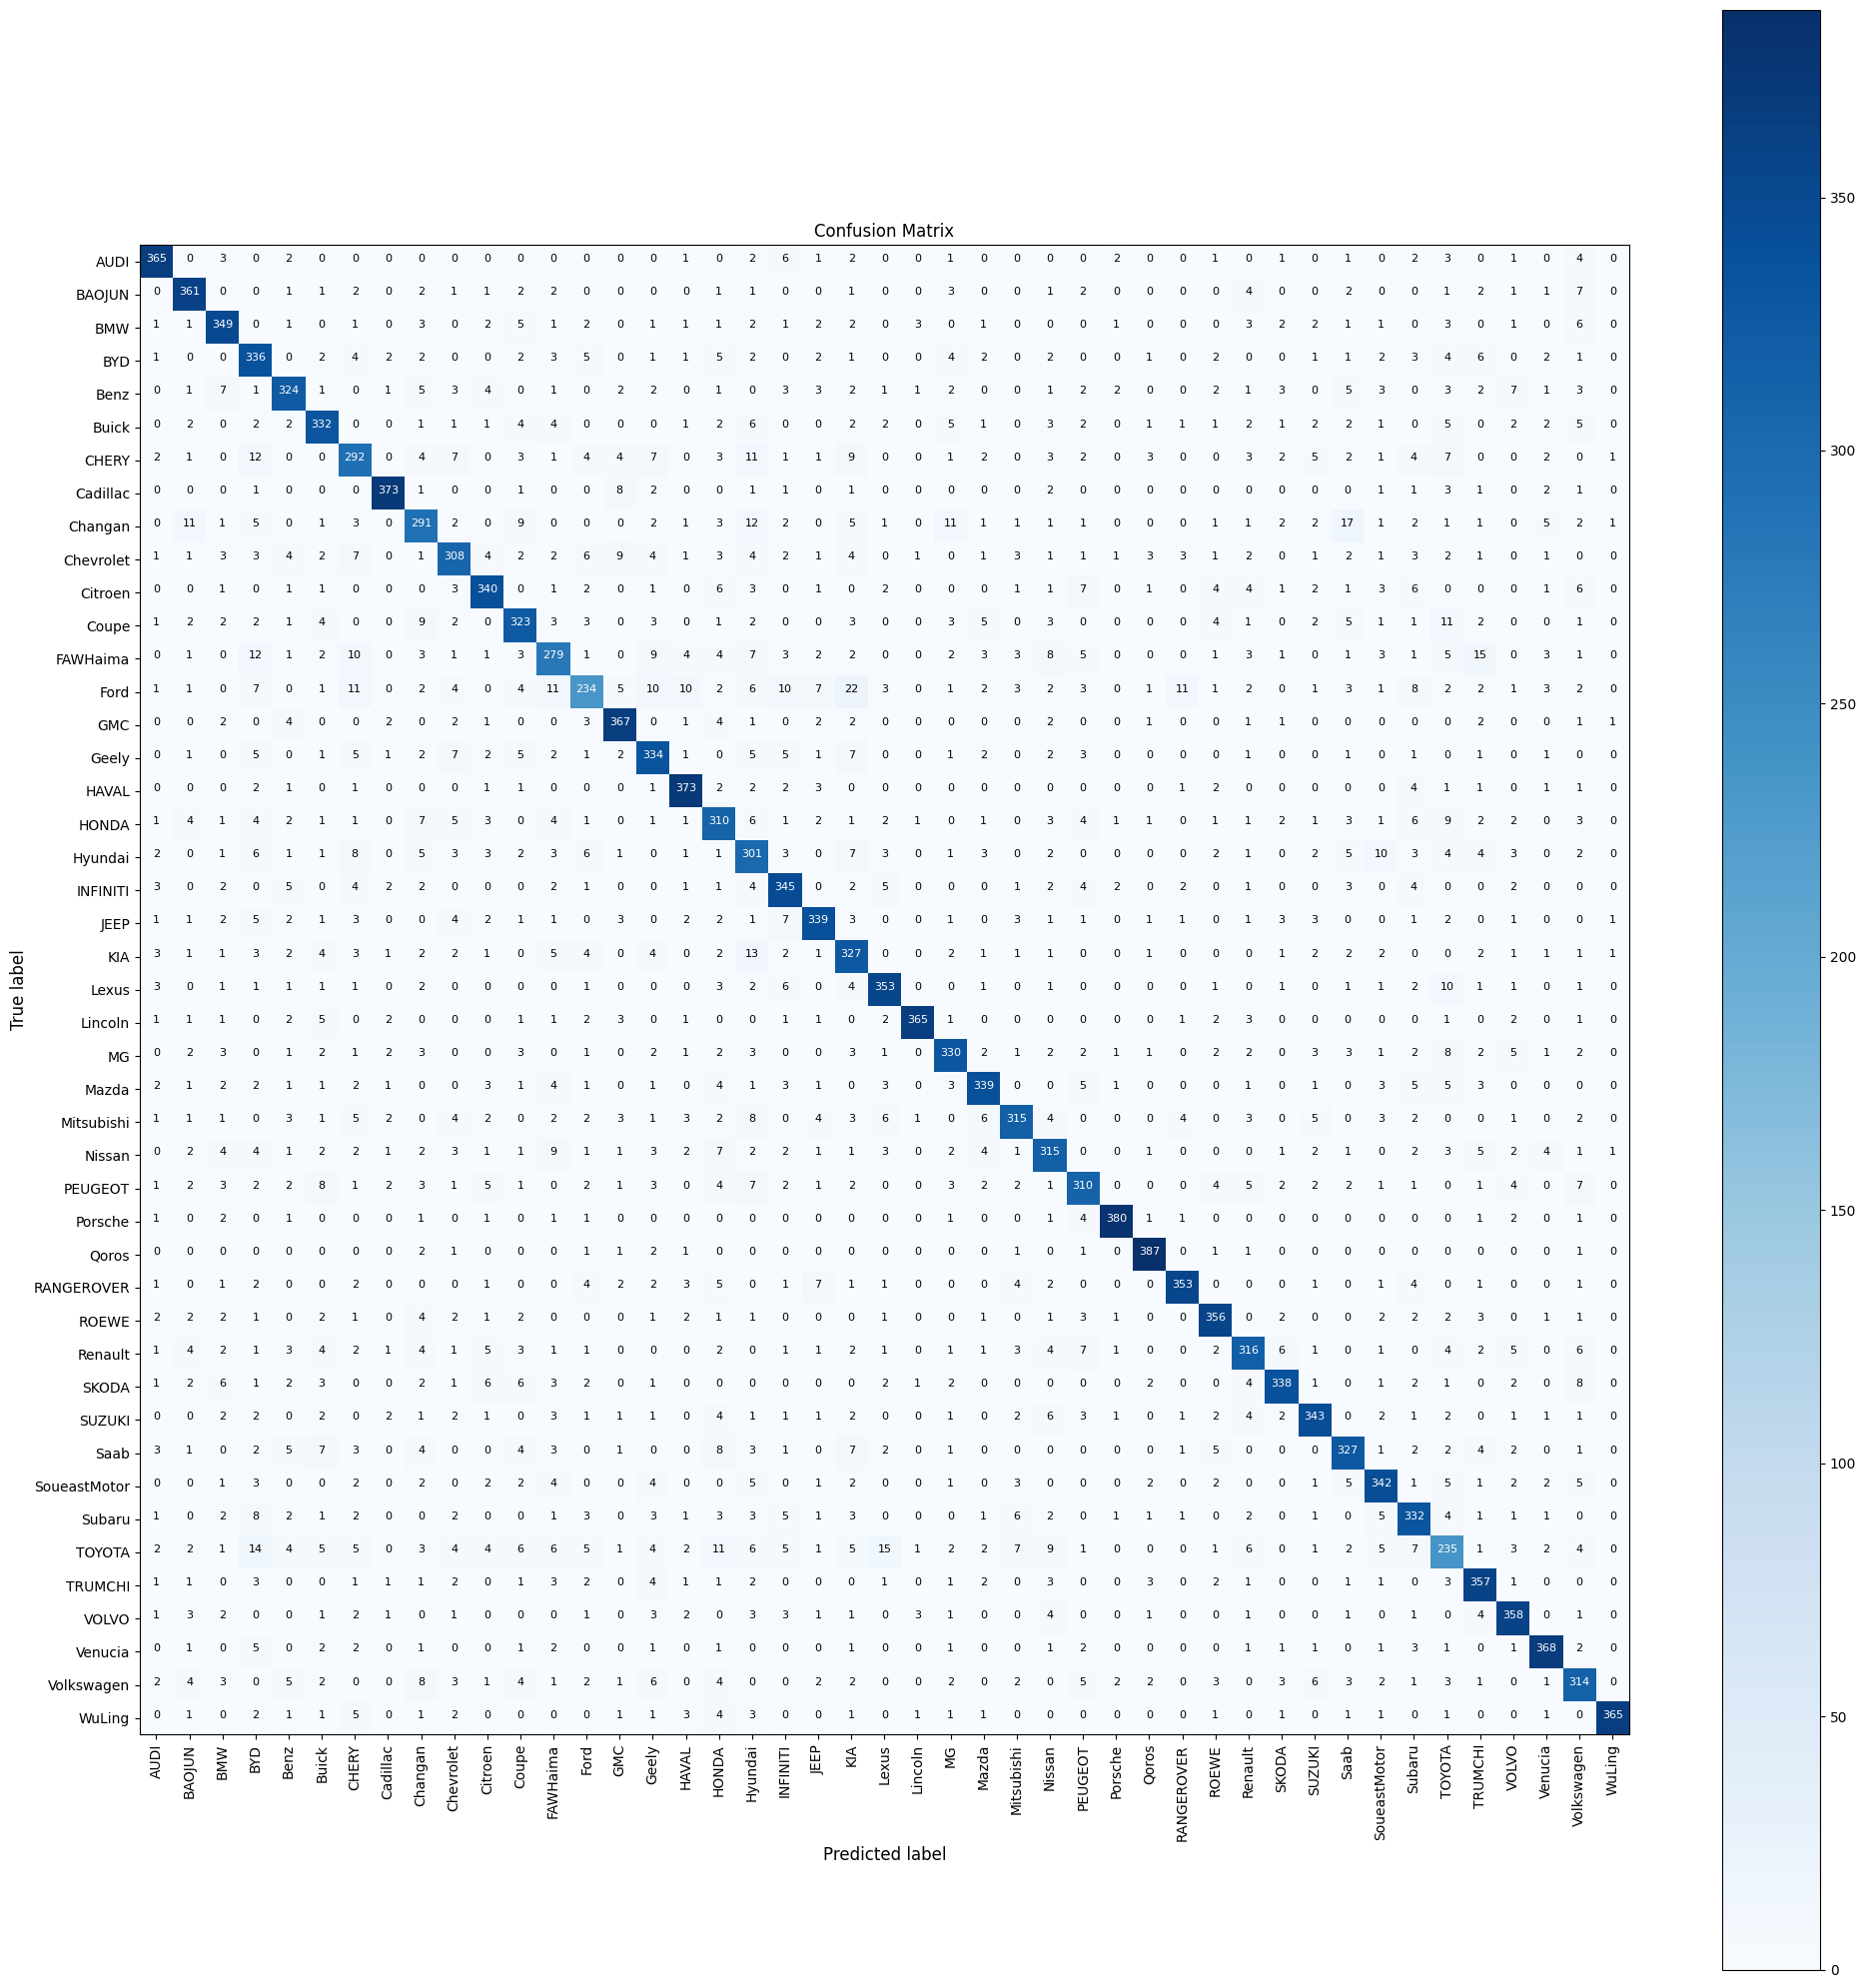

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20, 20))  # 增加图形尺寸
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=10)  # 调整标签角度和字体大小
    plt.yticks(tick_marks, classes, fontsize=10)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=8)  # 调整单元格内文字的字体大小

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)  # 调整坐标轴标签的字体大小
    plt.xlabel('Predicted label', fontsize=12)  # 调整坐标轴标签的字体大小


# 绘制混淆矩阵
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=class_labels, title='Confusion Matrix')
plt.savefig("Confusion_matrix.png") 
plt.show()


In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle


In [52]:

recall = recall_score(true_classes, predicted_classes, average='macro')
precision = precision_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')


logloss = log_loss(true_classes, predictions)
print(" (Precision): {:.4f}".format(precision))
print(" (Recall): {:.4f}".format(recall))
print("(F1 Score): {:.4f}".format(f1))
print("(Log Loss): {:.4f}".format(logloss))


 (Precision): 0.8342
 (Recall): 0.8336
(F1 Score): 0.8330
(Log Loss): 0.9684


E:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


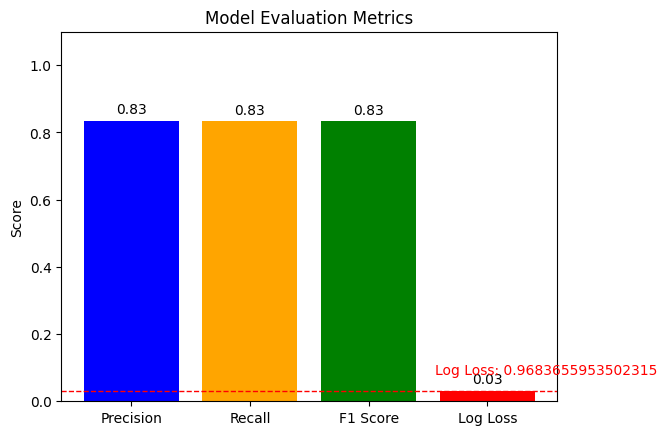

In [53]:
# Labels for the metrics
labels = ['Precision', 'Recall', 'F1 Score', 'Log Loss']
scores = [precision, recall, f1, logloss]

# Convert log loss to a scale that's comparable with other metrics for visualization purpose.
# This transformation is just for visualization and doesn't change the actual meaning or value of log loss.
# Since higher is better for the first three and lower is better for log loss, we subtract logloss from 1.
scores_for_visualization = [precision, recall, f1, 1 - logloss]

# Create a bar plot for the metrics
fig, ax = plt.subplots()
bars = plt.bar(labels, scores_for_visualization, color=['blue', 'orange', 'green', 'red'])

# Add the actual values above the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(round(height, 2)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.ylim(0, 1.1)  # Set y-axis limit to accommodate the log loss after transformation
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.axhline(1 - logloss, color='red', linestyle='dashed', linewidth=1)  # Reference line for log loss after transformation
plt.text(3.5, 1 - logloss + 0.05, f'Log Loss: {logloss}', color='red', ha='center')
plt.savefig("Model Evaluation Metrics.png")
plt.show()

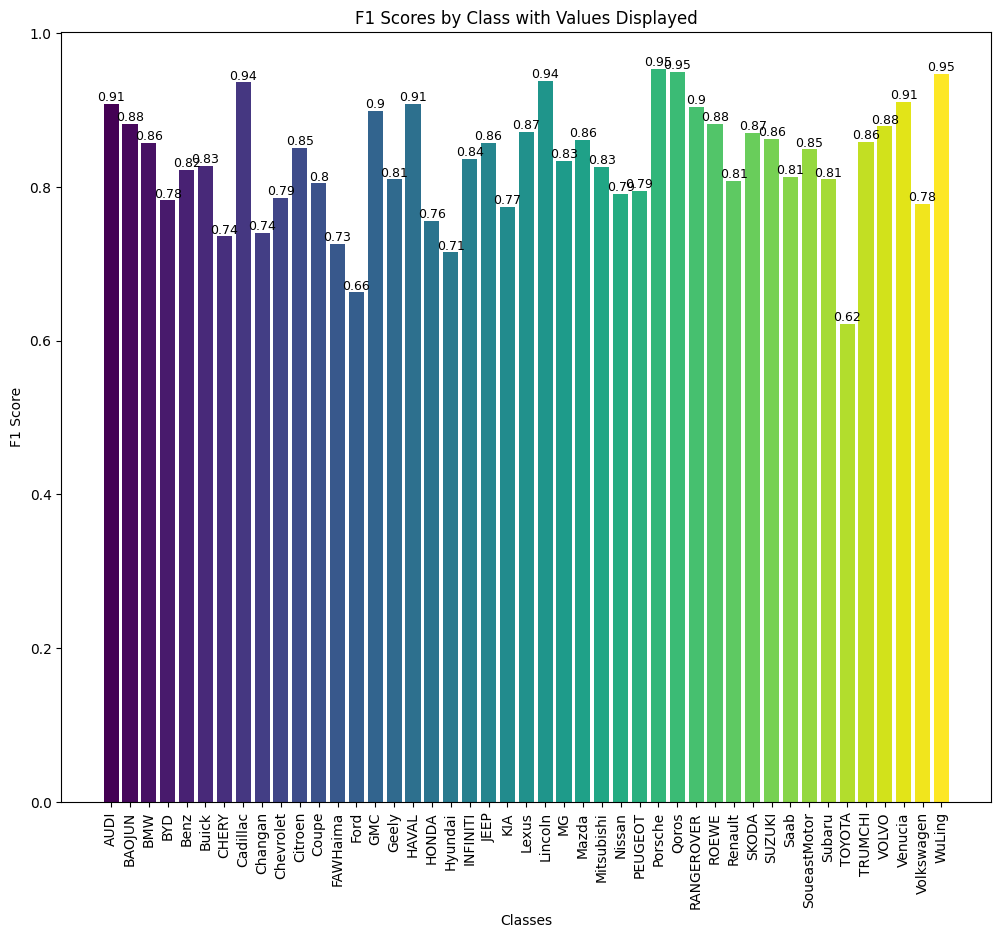

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 假设 `predictions` 和 `true_classes` 已经被定义
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 计算 F1 分数
f1_scores = f1_score(true_classes, predicted_classes, average=None, labels=np.unique(true_classes))

# 创建颜色映射
colors = plt.cm.viridis(np.linspace(0, 1, len(class_labels)))

# 绘制每个类的 F1 分数，并使用不同的颜色
plt.figure(figsize=(12, 10))
bars = plt.bar(class_labels, f1_scores, color=colors)

# 在每个条形上添加数值标签
for bar, score in zip(bars, f1_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(score, 2), ha='center', va='bottom', fontsize=9)

plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.xticks(rotation=90)  # 将类别标签旋转90度
plt.title('F1 Scores by Class with Values Displayed')
plt.savefig("F1 Scores by Classes.png")
plt.show()


In [54]:
# 假定你的类别标签为0到n_classes-1
n_classes = predictions.shape[1]
true_classes_bin = label_binarize(true_classes, classes=range(n_classes))


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2524\396016230.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


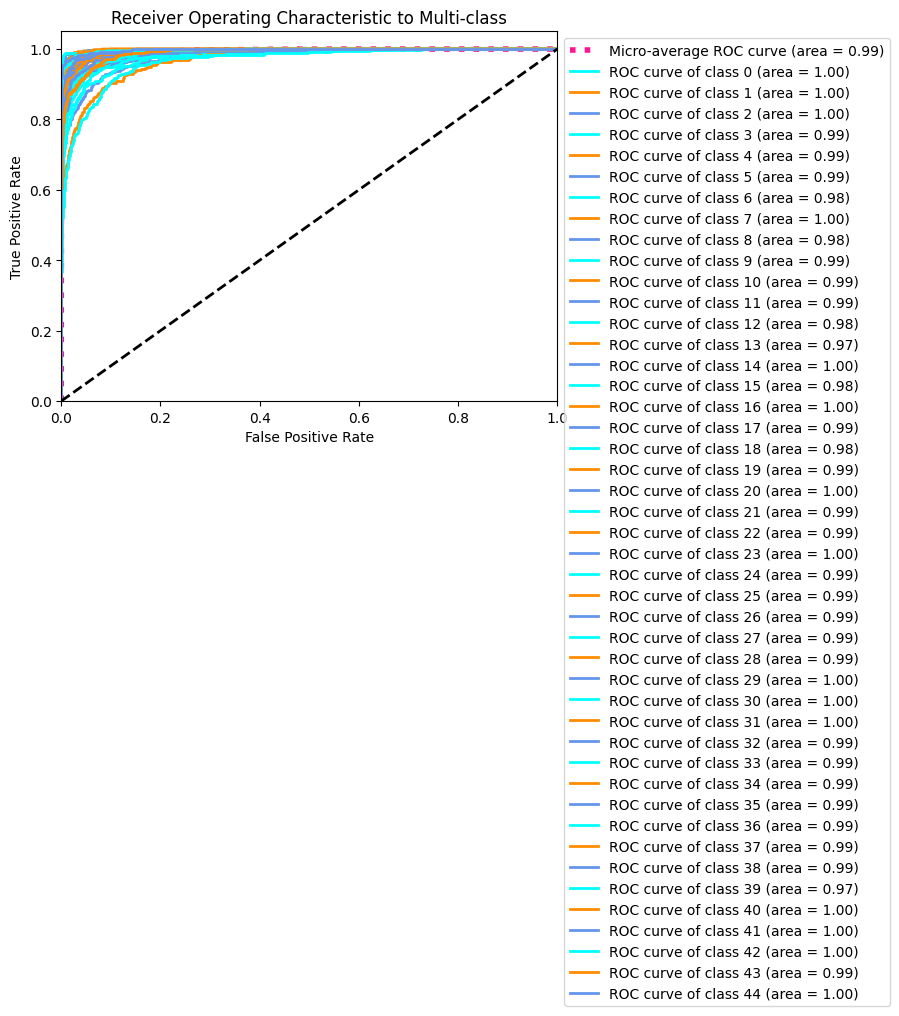

In [55]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(true_classes_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
#plt.figure(dpi=600)
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-class')
plt.legend(loc="lower right")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout() 

plt.show()
#plt.save



In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 计算微平均精确度、召回率和F1得分
micro_precision = precision_score(true_classes, predicted_classes, average='micro')
micro_recall = recall_score(true_classes, predicted_classes, average='micro')
micro_f1 = f1_score(true_classes, predicted_classes, average='micro')

# 总体准确率也可以作为微平均精确度和召回率的指标
overall_accuracy = accuracy_score(true_classes, predicted_classes)

kappa, macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1, overall_accuracy


(0.8289392605018054,
 0.8330027827581844,
 0.8327490228922391,
 0.832117255794581,
 0.8335741275839076,
 0.8335741275839076,
 0.8335741275839076,
 0.8335741275839076)

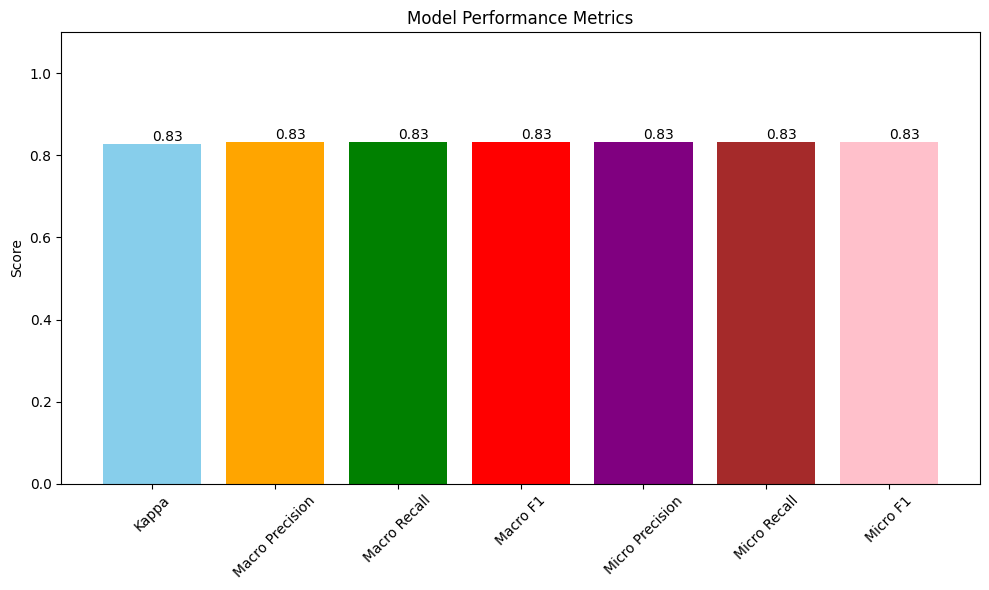

In [57]:
import matplotlib.pyplot as plt

# 定义要可视化的指标和它们的值
metrics = ['Kappa', 'Macro Precision', 'Macro Recall', 'Macro F1', 'Micro Precision', 'Micro Recall', 'Micro F1']
values = [kappa, macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1]

# 创建一个柱状图
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['skyblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink'])

# 在每个柱子上方添加值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  # va='bottom' to make the text centered.

plt.ylim(0, 1.1)  # 设置y轴的范围
plt.xticks(rotation=45)  # 旋转x轴的标签，以便它们更容易阅读
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.tight_layout()  # 调整整体布局以避免重叠

plt.show()



In [58]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


              precision    recall  f1-score   support

        AUDI       0.90      0.92      0.91       398
      BAOJUN       0.86      0.90      0.88       400
         BMW       0.84      0.87      0.86       400
         BYD       0.73      0.84      0.78       400
        Benz       0.84      0.81      0.82       400
       Buick       0.82      0.83      0.83       398
       CHERY       0.74      0.73      0.74       400
    Cadillac       0.94      0.93      0.94       400
     Changan       0.75      0.73      0.74       400
   Chevrolet       0.80      0.77      0.79       400
     Citroen       0.85      0.85      0.85       400
       Coupe       0.80      0.81      0.80       400
    FAWHaima       0.76      0.70      0.73       400
        Ford       0.76      0.58      0.66       400
         GMC       0.88      0.92      0.90       400
       Geely       0.79      0.83      0.81       400
       HAVAL       0.88      0.93      0.91       400
       HONDA       0.74    

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2524\861871940.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=report_df.index, x='precision', data=report_df, palette='Blues_d')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2524\861871940.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=report_df.index, x='recall', data=report_df, palette='Greens_d')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2524\861871940.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=report_df.index, x='f1-score', data=report_df, pa

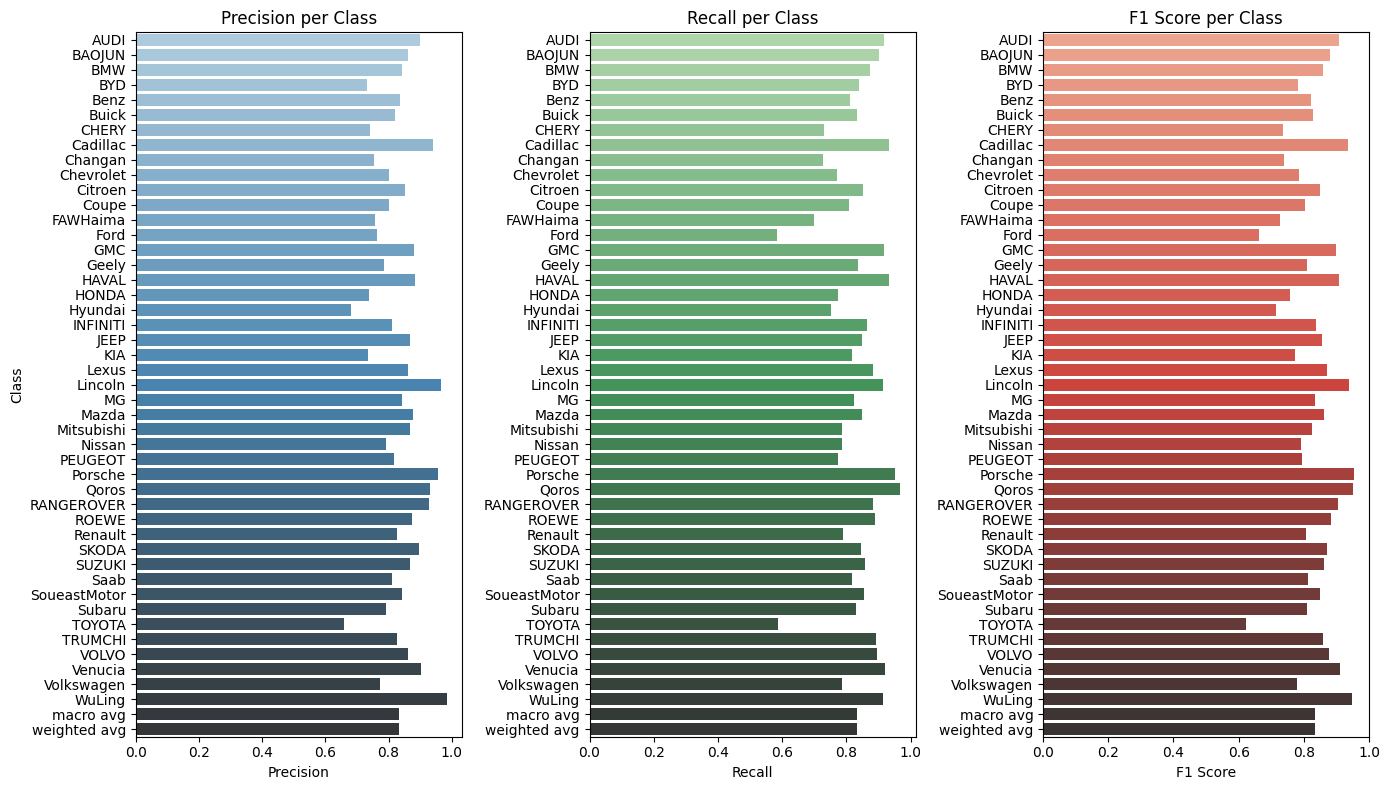

In [59]:
import pandas as pd
import seaborn as sns

# 将报告转换为DataFrame以便于可视化
report_df = pd.DataFrame(report).transpose()

# 删除'accuracy'行，因为它不适用于单个类别的可视化
report_df = report_df.drop('accuracy', errors='ignore')

# 可视化精确度、召回率和F1得分
plt.figure(figsize=(14, 8))

# 精确度条形图
plt.subplot(1, 3, 1)
sns.barplot(y=report_df.index, x='precision', data=report_df, palette='Blues_d')
plt.title('Precision per Class')
plt.xlabel('Precision')
plt.ylabel('Class')

# 召回率条形图
plt.subplot(1, 3, 2)
sns.barplot(y=report_df.index, x='recall', data=report_df, palette='Greens_d')
plt.title('Recall per Class')
plt.xlabel('Recall')
plt.ylabel('')

# F1得分条形图
plt.subplot(1, 3, 3)
sns.barplot(y=report_df.index, x='f1-score', data=report_df, palette='Reds_d')
plt.title('F1 Score per Class')
plt.xlabel('F1 Score')
plt.ylabel('')

plt.tight_layout()

plt.show()



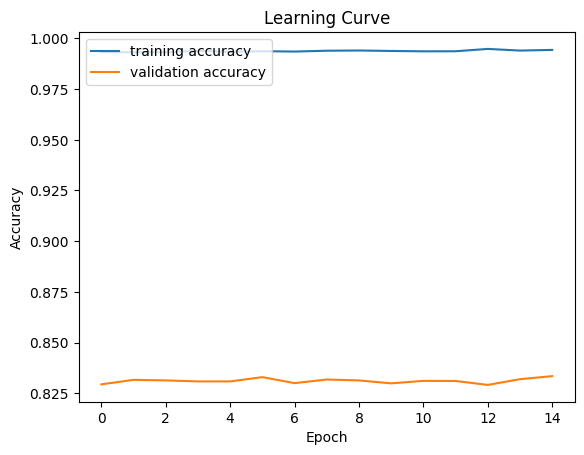

In [60]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Learning Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [61]:
from sklearn.metrics import matthews_corrcoef

# MCC calculation
mcc = matthews_corrcoef(true_classes, predicted_classes)
print(f'Matthews correlation coefficient: {mcc}')


Matthews correlation coefficient: 0.8298305188795287


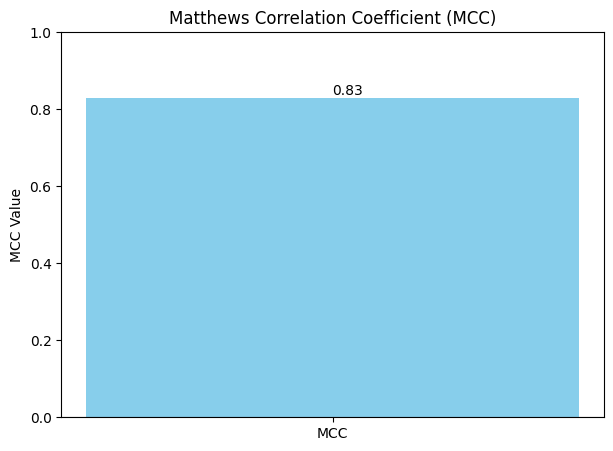

In [62]:
mcc_value = matthews_corrcoef(true_classes, predicted_classes)

# 可视化MCC值
plt.figure(figsize=(7, 5))
bars = plt.bar(['MCC'], [mcc_value], color=['skyblue'])

# 添加数值标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

# 设置y轴的范围以便更好地显示MCC值
plt.ylim(0, 1)
plt.axhline(0, color='grey', linewidth=0.8)  # 添加0参考线
plt.title('Matthews Correlation Coefficient (MCC)')
plt.ylabel('MCC Value')

plt.show()

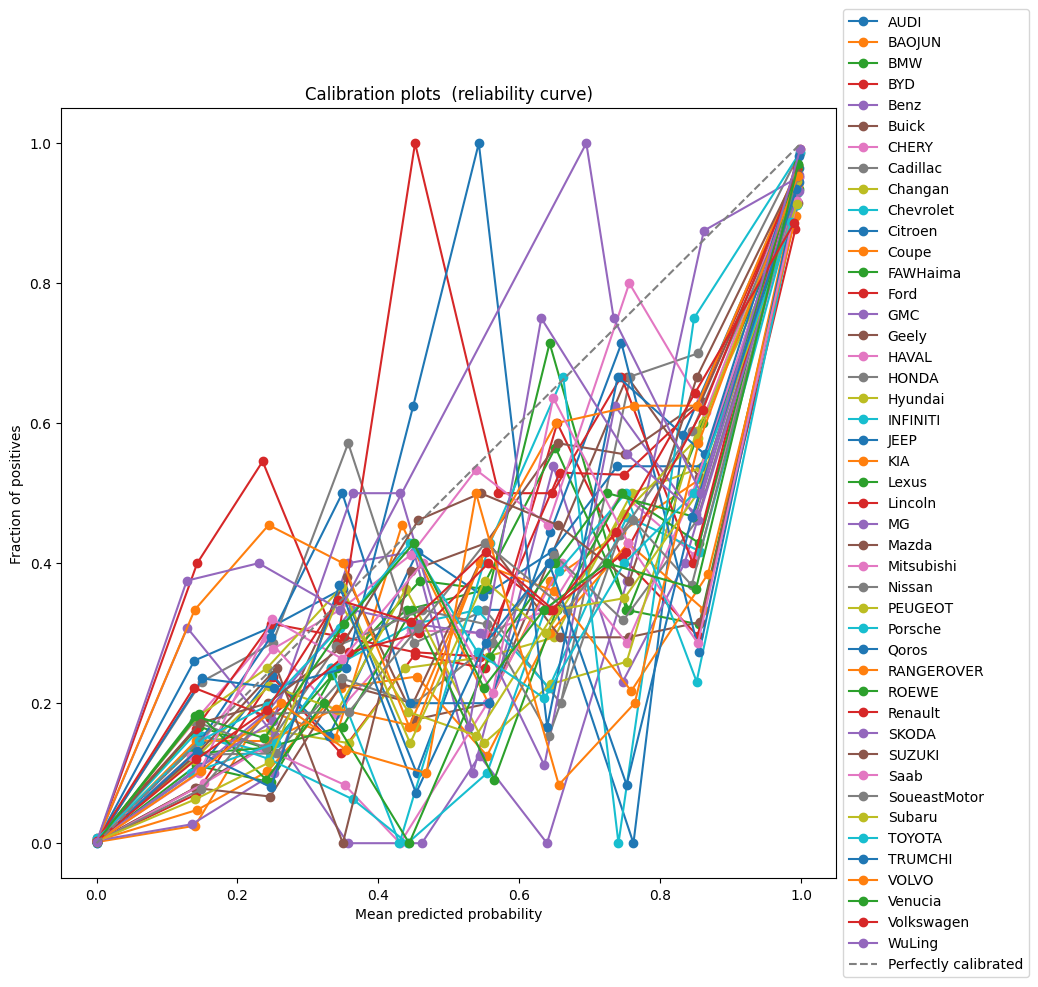

In [63]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
for i, class_label in enumerate(class_labels):
    # 计算每个类别的校准曲线
    prob_true, prob_pred = calibration_curve(y_test_binarized[:, i], predictions[:, i], n_bins=10)
    
    plt.plot(prob_pred, prob_true, marker='o', label=class_labels[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.ylabel('Fraction of positives')
plt.xlabel('Mean predicted probability')
plt.legend(loc="best")
plt.title('Calibration plots  (reliability curve)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
